# Risk forecasting DNN model

### Hyperparameters

In [1]:
# options
ACTIVE_LEARNING = True
PROGRESSIVE_TRAINING = True
BASELINE = True
LOW_BIT_TRAINING = False

# data params
SERIES_INTERVAL = '1d'
LOOKBACK_WINDOW = 10
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.8

# general model params 
EPOCHS = 100
BATCH_SIZE = 32
NODES_PER_LAYER = 10

# active learning params
AL_ITERATIONS = 100
AL_SAMPLE = 100
AL_EPOCHS = 2

# progressive training params
PRETRAINING_EPOCHS = 30
TUNING_EPOCHS = 30

# low-bit training
MIXED_PRECISION = 'mixed_float16'
HIGH_PRECISION = 'float32'

### Imports

In [2]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from time import time
import yfinance as yf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

from scipy.stats import norm

In [4]:
# check if connected to a GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d5e71dba-eaa2-be3f-a526-eb877483effd)


### Mixed Precision Training

In [5]:
# create dtype policy, specifying dtype layers run in
if LOW_BIT_TRAINING:
    policy = mixed_precision.Policy(MIXED_PRECISION)
else:
    policy = mixed_precision.Policy(HIGH_PRECISION)

mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Compute dtype: float32
Variable dtype: float32


### Data curation and manipulation

In [6]:
# formula for historical volatility
def compute_volatility(window):
    _v = window - np.mean(window)
    _v = np.square(_v)
    _v = np.sum(_v)
    _v = _v / LOOKBACK_WINDOW
    _v = np.sqrt(_v)

    return _v

In [7]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(start='1950-01-04', end='2022-08-02', interval=SERIES_INTERVAL)

close = sp500_history.Close.loc[sp500_history.Close != 0]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = [compute_volatility(log_returns[i: i + LOOKBACK_WINDOW]) for i in range(log_returns.shape[0] - LOOKBACK_WINDOW)]

# gather other variables
_open = sp500_history.Open[1:]
_high = sp500_history.High[1:]
_low = sp500_history.Low[1:]
_volume = sp500_history.Volume[1:]

close = close[1:]
volatility = pd.Series(volatility, index=log_returns[LOOKBACK_WINDOW:].keys())

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'close': (close - close.min()) / close.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'returns': log_returns / np.abs(log_returns).max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# fill nan values in volatility column (these won't be used)
X.volatility = X.volatility.fillna(0)

X

,open,close,high,low,volume,returns,volatility
Date,,,,,,,
1950-01-05,0.003524,0.000054,0.000054,0.000054,0.000163,0.020684,0.000000
1950-01-06,0.003534,0.000065,0.000064,0.000065,0.000116,0.012878,0.000000
1950-01-09,0.003555,0.000085,0.000085,0.000086,0.000161,0.025642,0.000000
1950-01-10,0.003545,0.000075,0.000075,0.000075,0.000129,-0.012802,0.000000
1950-01-11,0.003557,0.000088,0.000087,0.000088,0.000170,0.015358,0.000000
...,...,...,...,...,...,...,...
2022-07-26,0.822814,0.813996,0.816945,0.814652,0.269089,-0.050701,0.126826
2022-07-27,0.822442,0.835378,0.834864,0.823165,0.312798,0.112753,0.129777
2022-07-28,0.837990,0.845556,0.843038,0.831855,0.338870,0.052666,0.147466


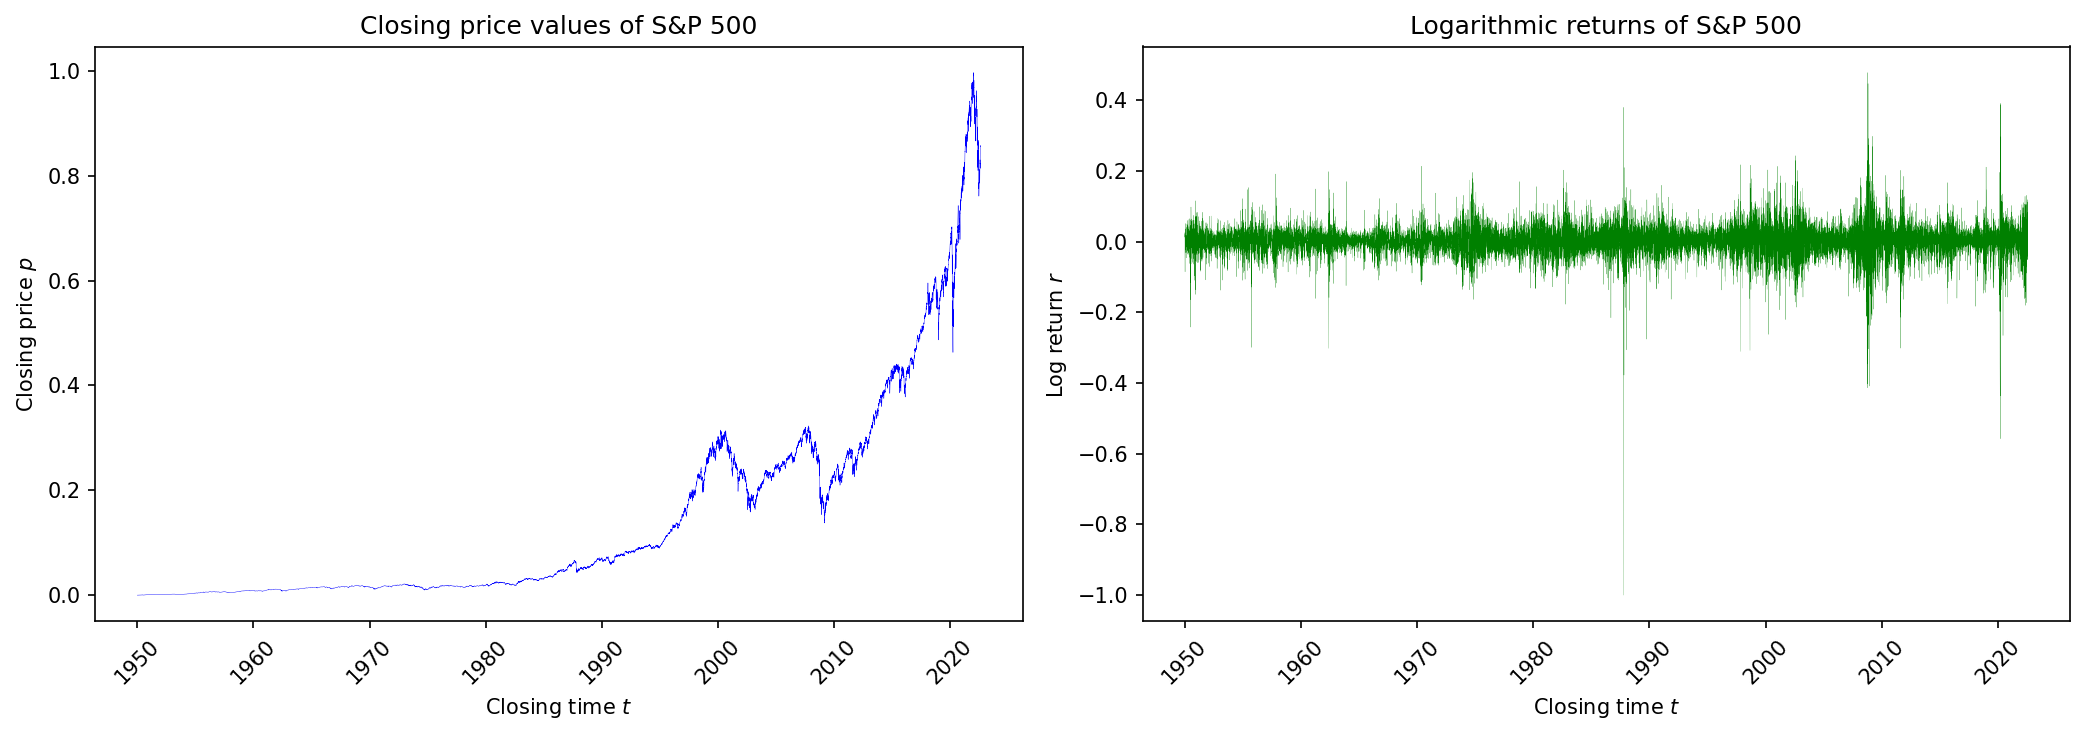

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

try:
    fig.savefig('./drive/MyDrive/UCL/Thesis/results/dataset.png')
except FileNotFoundError:
    fig.savefig('./dataset.png')

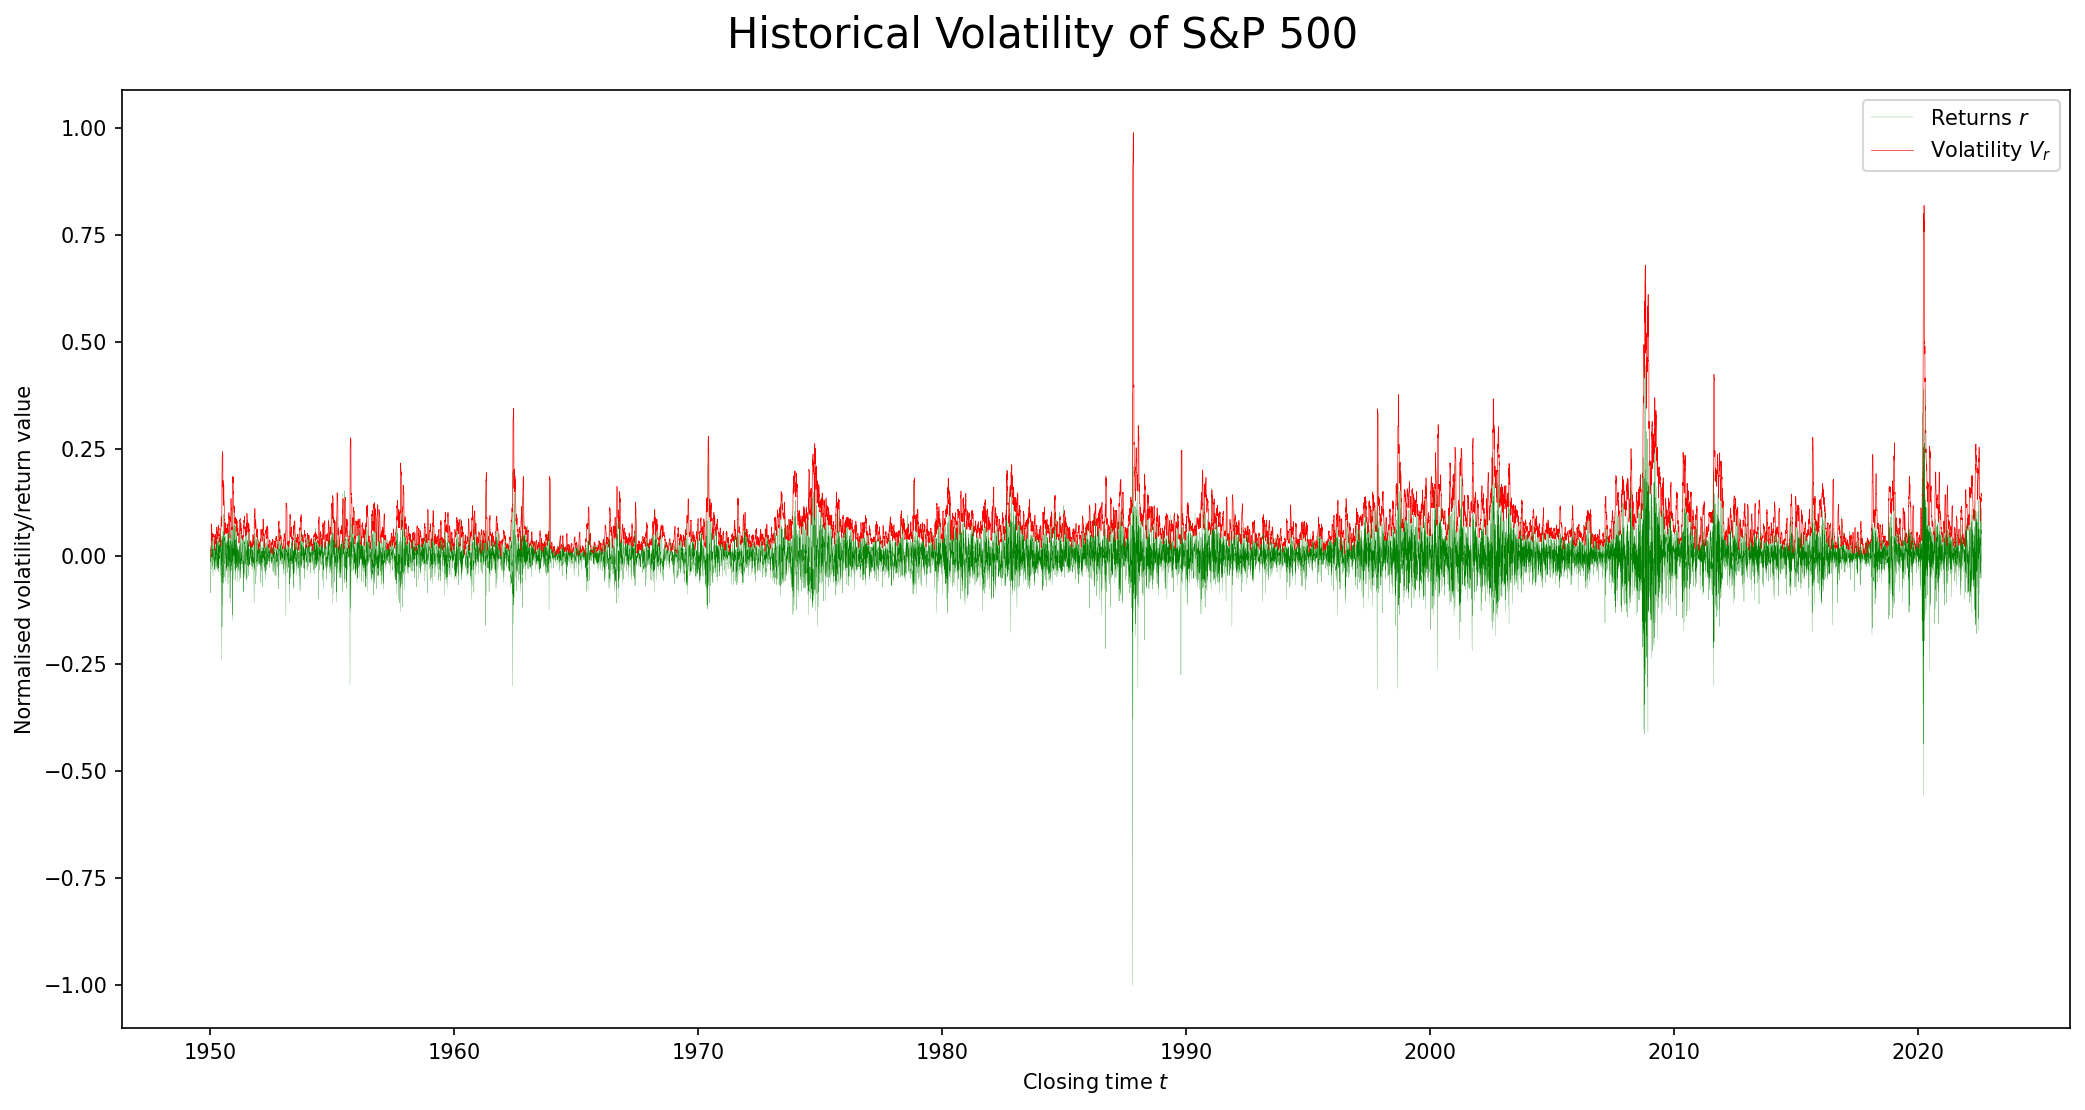

In [9]:
# plot computed volatility
fig, ax = plt.subplots(figsize=(14, 7), dpi=150)

ax.plot(X.returns, linewidth=0.1, color='g', label='Returns $r$')
ax.plot(X.volatility, linewidth=0.3, color='r', label='Volatility $V_r$')
ax.set(xlabel=r'Closing time $t$', ylabel='Normalised volatility/return value')
ax.legend()

fig.suptitle("Historical Volatility of S&P 500", y=1.05, fontsize=20)
plt.tight_layout()
plt.show()

try:
    fig.savefig('./drive/MyDrive/UCL/Thesis/results/volatility.png')
except FileNotFoundError:
    fig.savefig('./volatility.png')

In [10]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW):
    # compute volatility 
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + 1])

# convert X, y to numpy arrays (and scale volatility)
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:split]
y_train = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]

X_train, y_train = shuffle(X_train, y_train)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print("Train:", X_train.shape, y_train.shape, '\nTest: ', X_test.shape, y_test.shape)

80% training data, 20% testing data
Train: (14600, 10, 7) (14600, 1) 
Test:  (3651, 10, 7) (3651, 1)


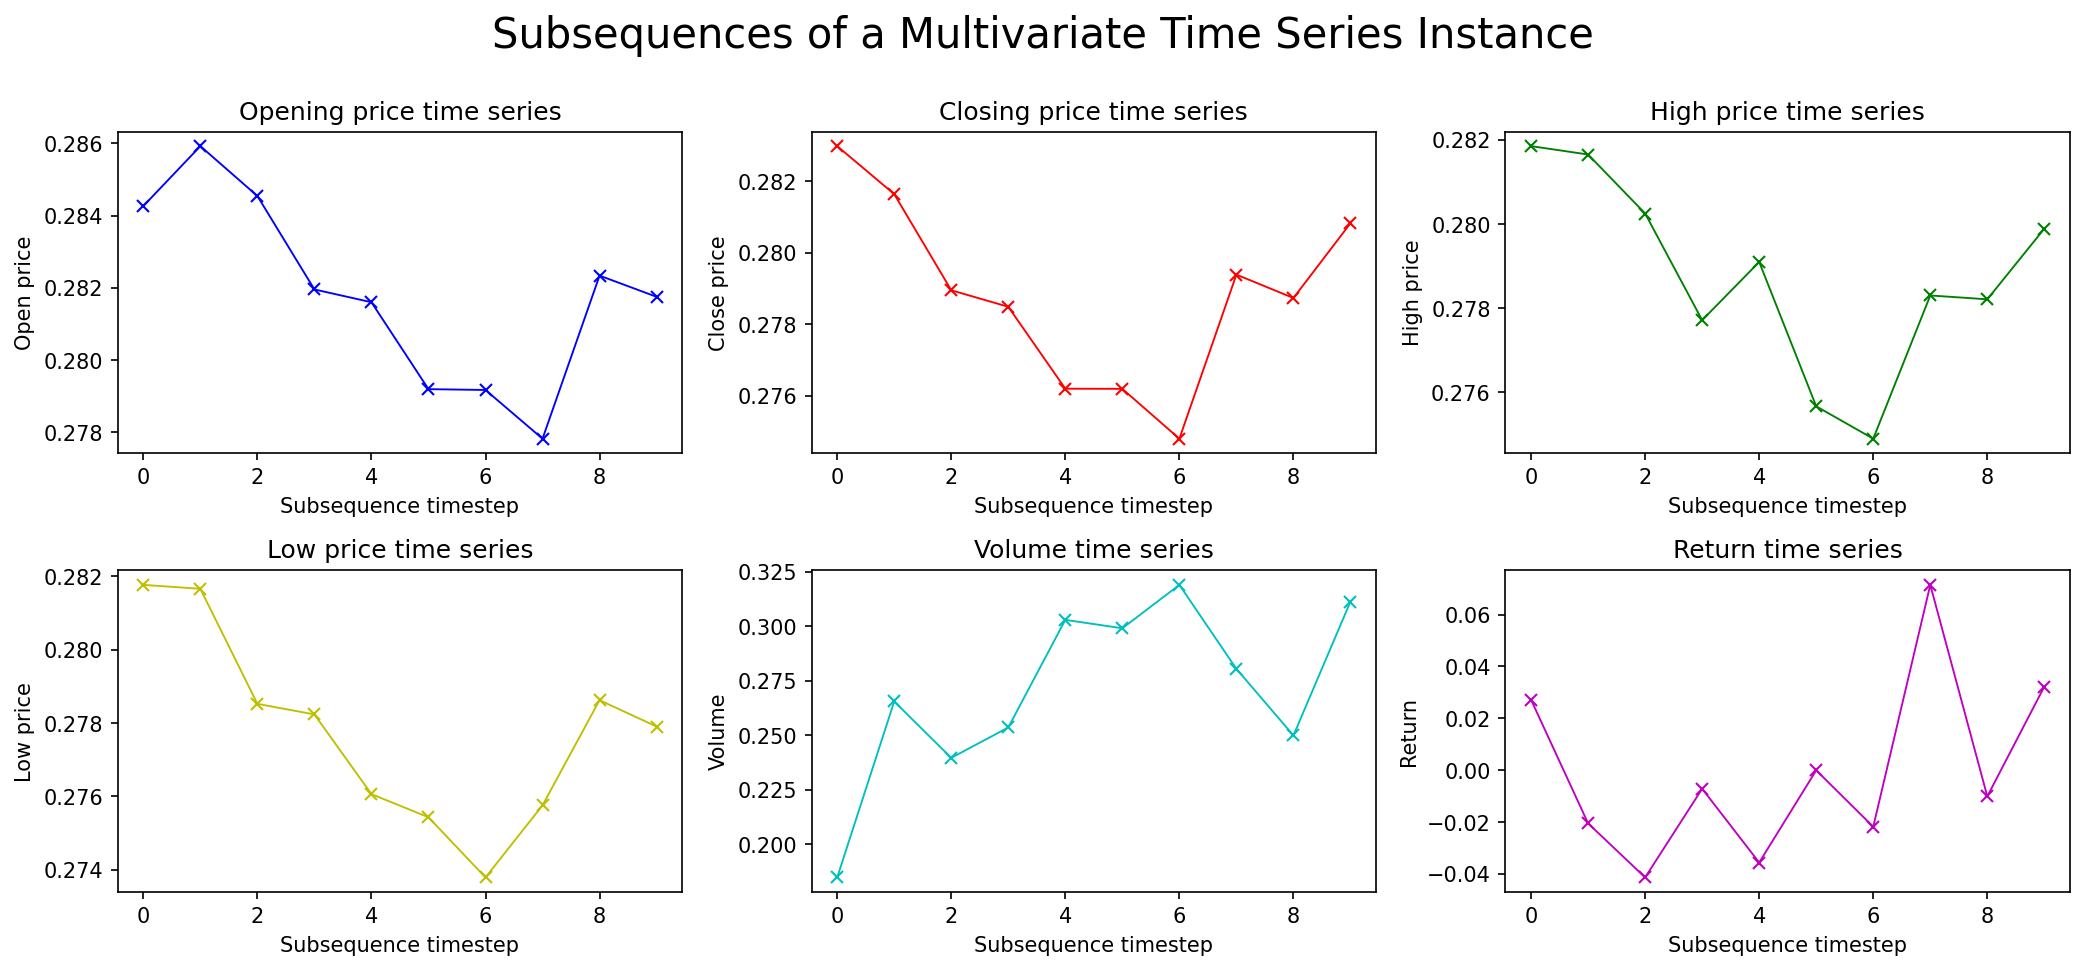

In [11]:
# examples of individual variable time series instance
fig, ax = plt.subplots(2, 3, figsize=(14, 6), dpi=150)

np.random.seed(123)
random_index = np.random.randint(0, y_data.shape[0])
time_series = X_data[random_index]
label = y_data[random_index][0]

ax[0, 0].plot(time_series[:, 0], color='b', marker='x', linewidth=0.9)
ax[0, 0].set(title=f'Opening price time series', xlabel=r'Subsequence timestep', ylabel=r'Open price')

ax[0, 1].plot(time_series[:, 1], color='r', marker='x', linewidth=0.9)
ax[0, 1].set(title=f'Closing price time series', xlabel=r'Subsequence timestep', ylabel=r'Close price')

ax[0, 2].plot(time_series[:, 2], color='g', marker='x', linewidth=0.9)
ax[0, 2].set(title=f'High price time series', xlabel=r'Subsequence timestep', ylabel=r'High price')

ax[1, 0].plot(time_series[:, 3], color='y', marker='x', linewidth=0.9)
ax[1, 0].set(title=f'Low price time series', xlabel=r'Subsequence timestep', ylabel=r'Low price')

ax[1, 1].plot(time_series[:, 4], color='c', marker='x', linewidth=0.9)
ax[1, 1].set(title=f'Volume time series', xlabel=r'Subsequence timestep', ylabel=r'Volume')

ax[1, 2].plot(time_series[:, 5], color='m', marker='x', linewidth=0.9)
ax[1, 2].set(title=f'Return time series', xlabel=r'Subsequence timestep', ylabel=r'Return')

fig.suptitle("Subsequences of a Multivariate Time Series Instance", y=1.07, fontsize=20)
plt.tight_layout()
plt.show()

try:
    fig.savefig('./drive/MyDrive/UCL/Thesis/results/subsequences.png')
except FileNotFoundError:
    fig.savefig('./subsequences.png')

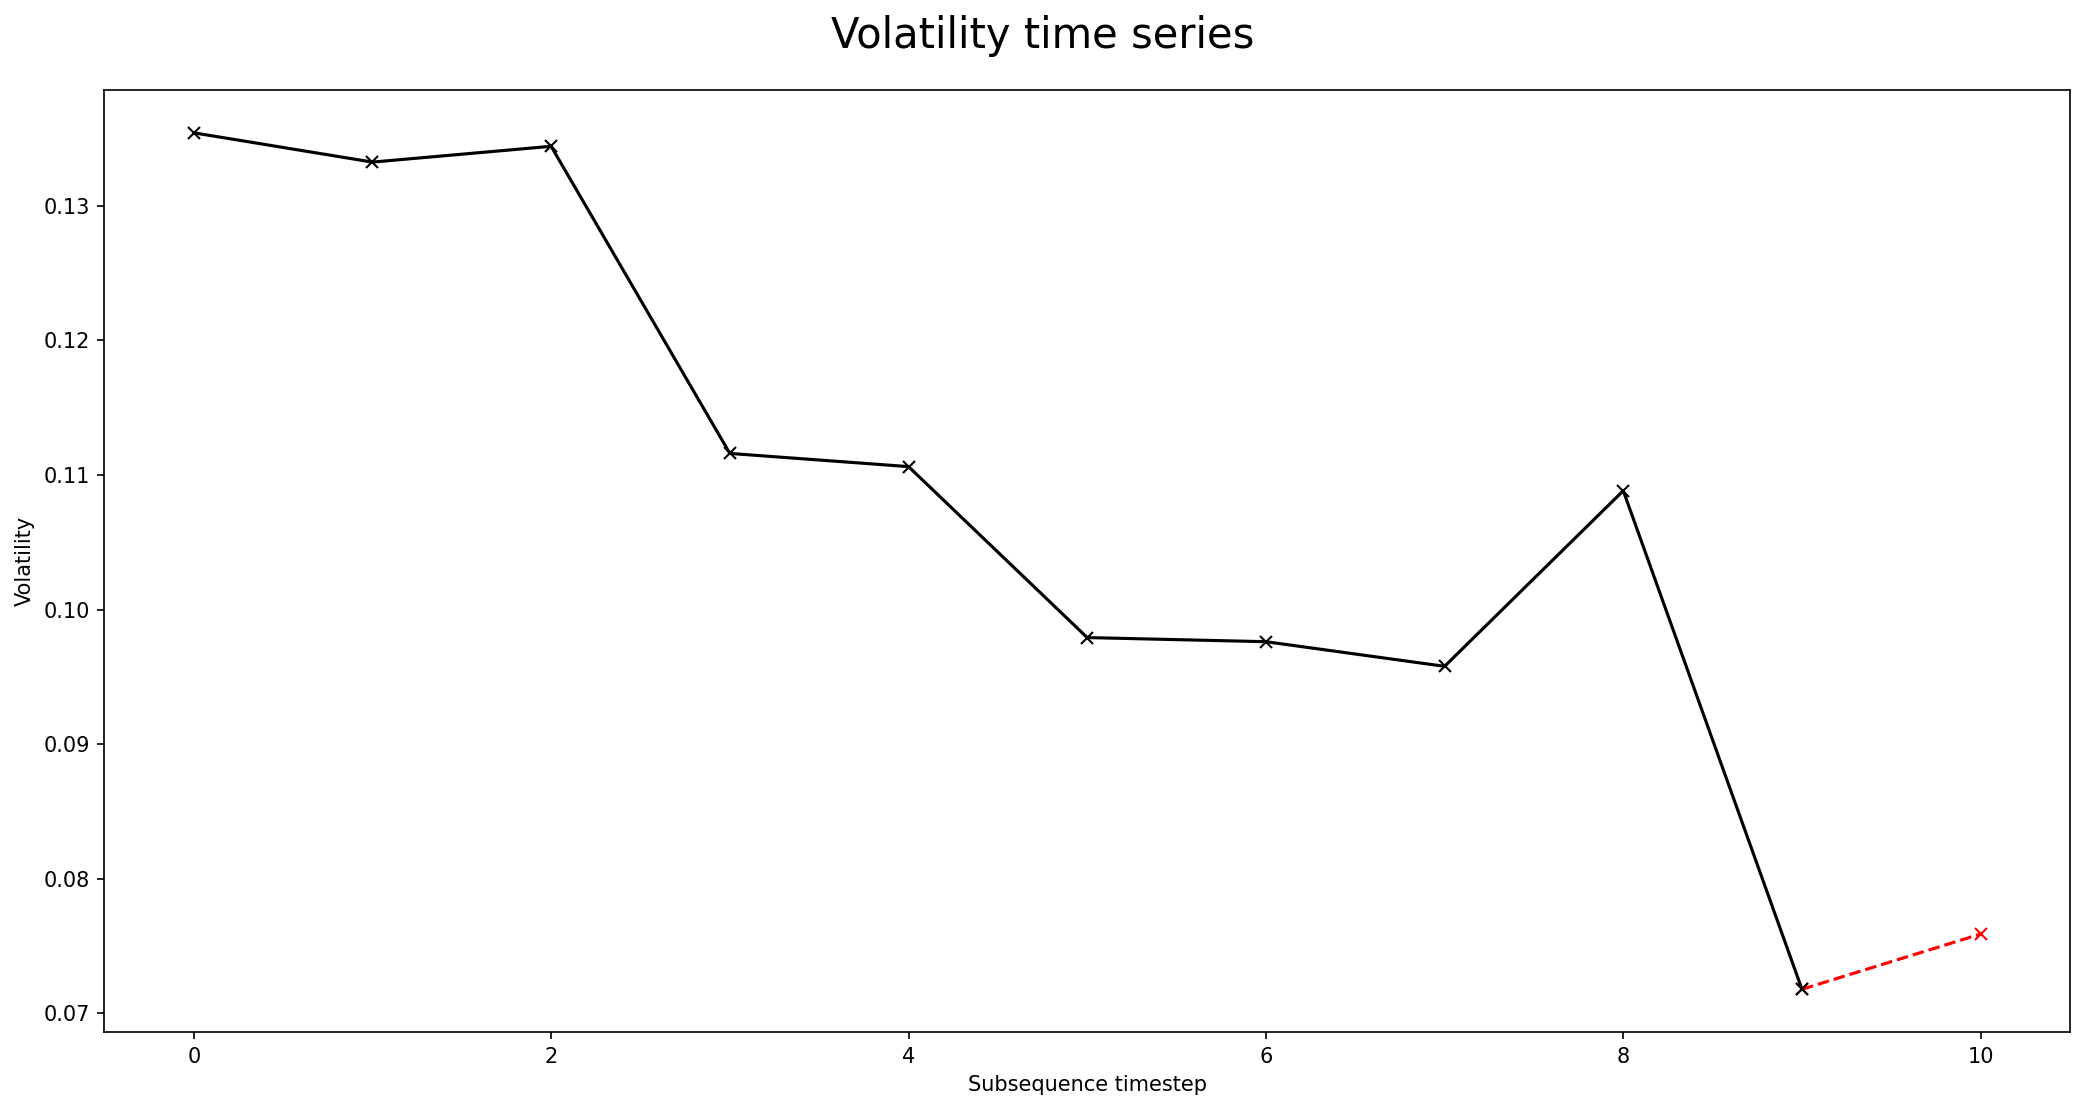

In [12]:
# example of volatility time series instance
fig, ax = plt.subplots(figsize=(14, 7), dpi=150)

ax.plot([9, 10], [time_series[:, 6][-1], label], color='r', marker='x', linestyle='dashed')
ax.plot(time_series[:, 6], color='k', marker='x')
ax.set(xlabel=r'Subsequence timestep', ylabel=r'Volatility')

fig.suptitle("Volatility time series", y=1.05, fontsize=20)
plt.tight_layout()
plt.show()

try:
    fig.savefig('./drive/MyDrive/UCL/Thesis/results/volatility-subsequence.png')
except FileNotFoundError:
    fig.savefig('./volatility-subsequence.png')

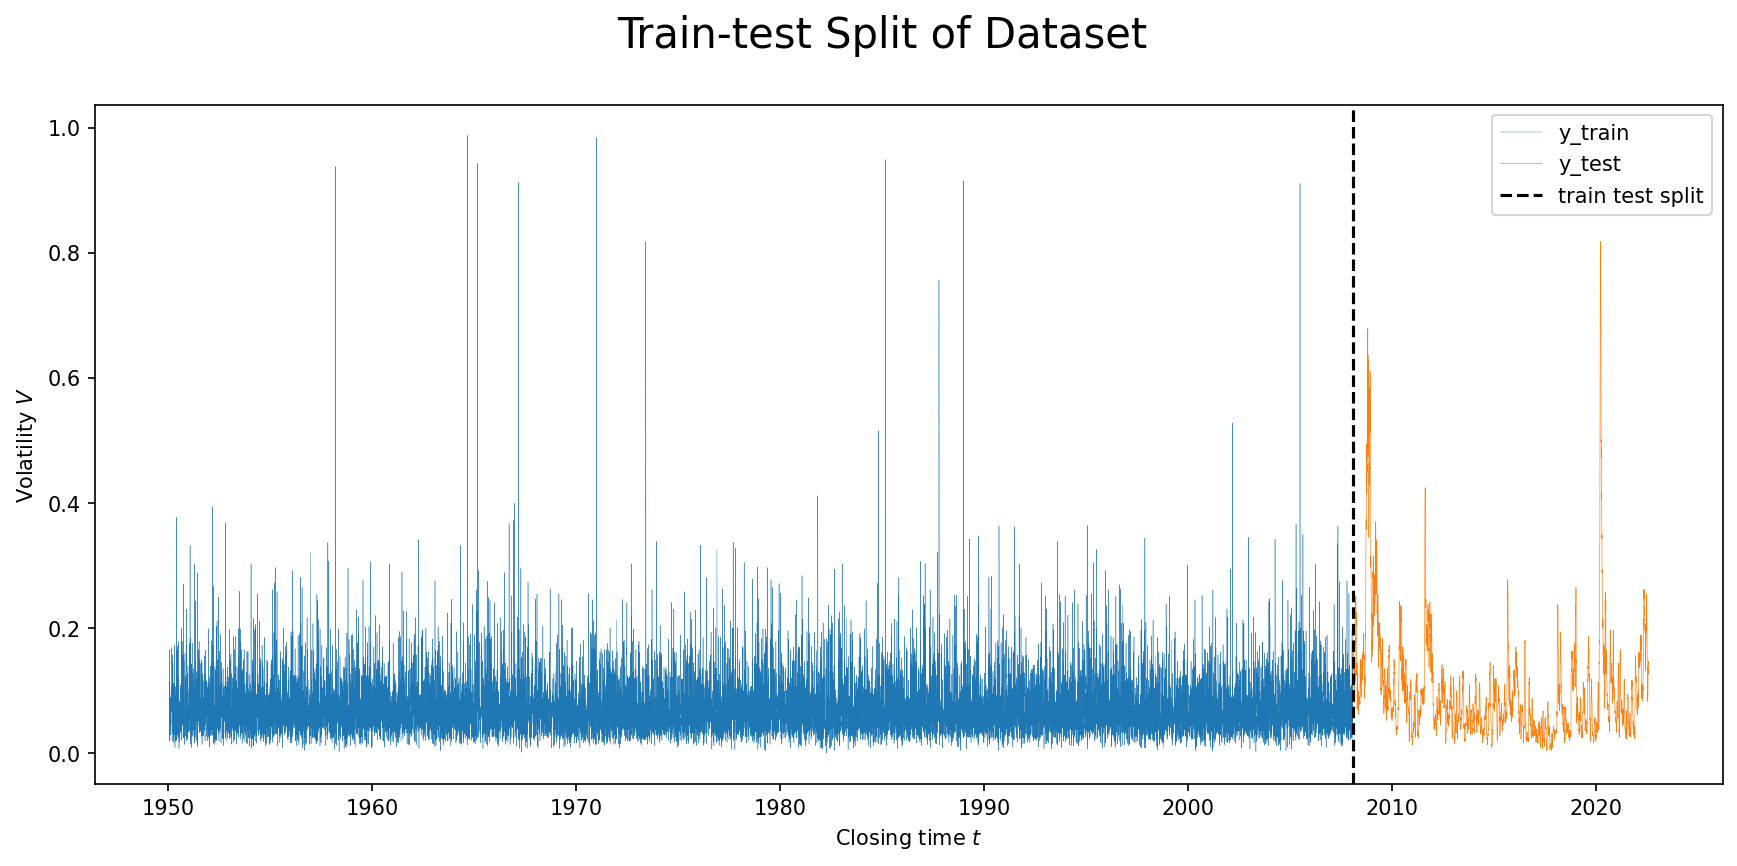

In [13]:
# plot the train-test split data
fig, ax = plt.subplots(figsize=(14, 6), dpi=150)

y_train_plot = y_train.flatten()
y_train_plot = pd.Series(y_train_plot, index=X.volatility[LOOKBACK_WINDOW: LOOKBACK_WINDOW + split].keys())

y_test_plot = y_test.flatten()
y_test_plot = pd.Series(y_test_plot, index=X.volatility[LOOKBACK_WINDOW + split:].keys())

ax.plot(y_train_plot, label='y_train', linewidth=0.2)
ax.plot(y_test_plot, label='y_test', linewidth=0.3)
ax.axvline(y_test_plot.keys()[0], color='k', linestyle='--', label='train test split')
ax.set(xlabel=r'Closing time $t$', ylabel=r'Volatility $V$')

fig.suptitle("Train-test Split of Dataset", fontsize=20)
ax.legend()
plt.show()

try:
    fig.savefig('./drive/MyDrive/UCL/Thesis/results/traintest-split.png')
except FileNotFoundError:
    fig.savefig('./traintest-split.png')

### Analysis Metrics

In [ ]:
# metric functions
def compute_mae(y_true, y_hat):
    _ae = np.abs(np.subtract(y_true, y_hat))
    _mae = _ae.mean()

    return _mae


def compute_rmse(y_true, y_hat):
    _se = np.square(np.subtract(y_true, y_hat))
    _rmse = np.sqrt(_se.mean())

    return _rmse


def compute_mape(y_true, y_hat):
    _ape = np.abs((y_true - y_hat) / y_true)
    _mape = _ape.mean() * 100

    return _mape

### Baseline comparison model (basic non-active, non-layer-wise training)

In [14]:
if BASELINE:
    # comparative model to progressively trained model
    comp_model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, input_shape=(X_train.shape[1:]), activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
        Dense(1, activation='linear')
    ])

    # compile and train comparison model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    comp_model.compile(loss='mae', optimizer=optim, metrics=['mse'])
    
    # train and evaluate 
    start_comp = time()
    hist = comp_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    total_time_comp = time() - start_comp
    history_comp = hist.history

    test_loss, test_acc = comp_model.evaluate(X_test, y_test)

Epoch 1/100
92/92 [==============================] - 8s 31ms/step - loss: 0.0311 - mse: 0.0022 - val_loss: 0.0233 - val_mse: 0.0013
Epoch 2/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0196 - mse: 9.0238e-04 - val_loss: 0.0192 - val_mse: 0.0011
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.0191 - mse: 8.5638e-04 - val_loss: 0.0186 - val_mse: 9.8410e-04
Epoch 4/100
92/92 [==============================] - 2s 18ms/step - loss: 0.0185 - mse: 8.1342e-04 - val_loss: 0.0189 - val_mse: 9.6579e-04
Epoch 5/100
92/92 [==============================] - 2s 18ms/step - loss: 0.0182 - mse: 7.9599e-04 - val_loss: 0.0178 - val_mse: 9.1531e-04
Epoch 6/100
92/92 [==============================] - 2s 18ms/step - loss: 0.0175 - mse: 7.0698e-04 - val_loss: 0.0176 - val_mse: 8.8064e-04
Epoch 7/100
92/92 [==============================] - 2s 20ms/step - loss: 0.0168 - mse: 6.5501e-04 - val_loss: 0.0161 - val_mse: 7.5741e-04
Epoch 8/100
92/92 [=============

In [15]:
if BASELINE:
    # Comparison model architecture
    comp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 10)            720       
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 lstm_2 (LSTM)               (None, 10)                840       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 2,411
Trainable params: 2,411
Non-trainable params: 0
_________________________________________________________________


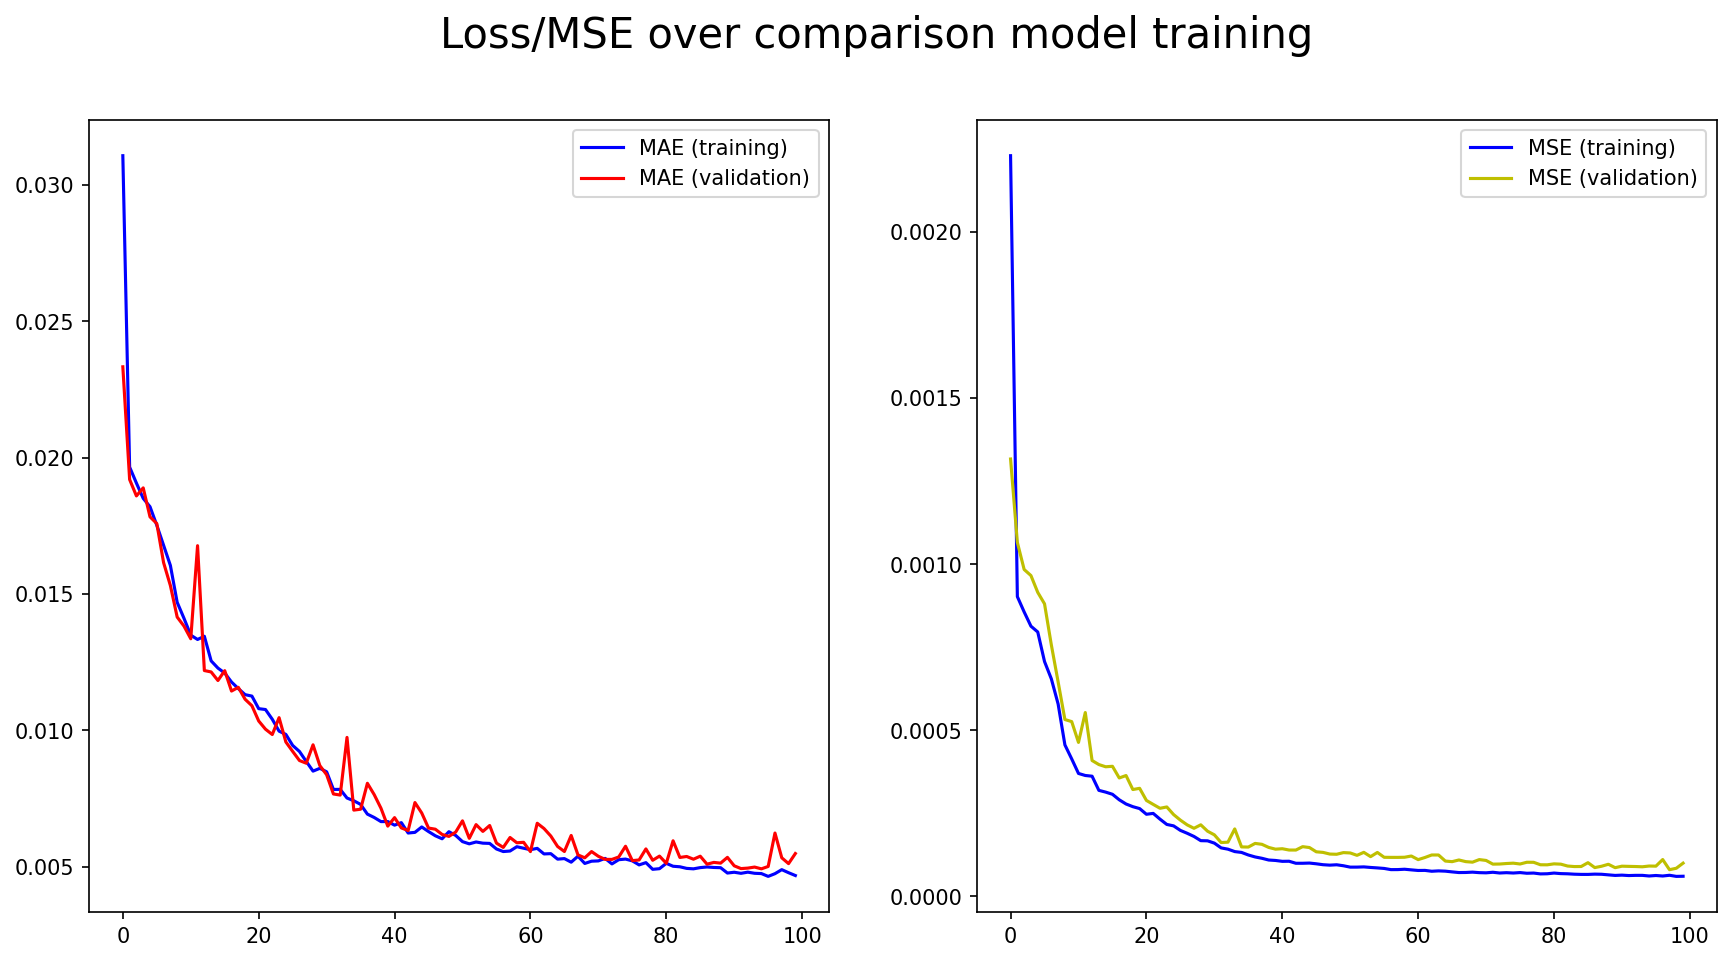

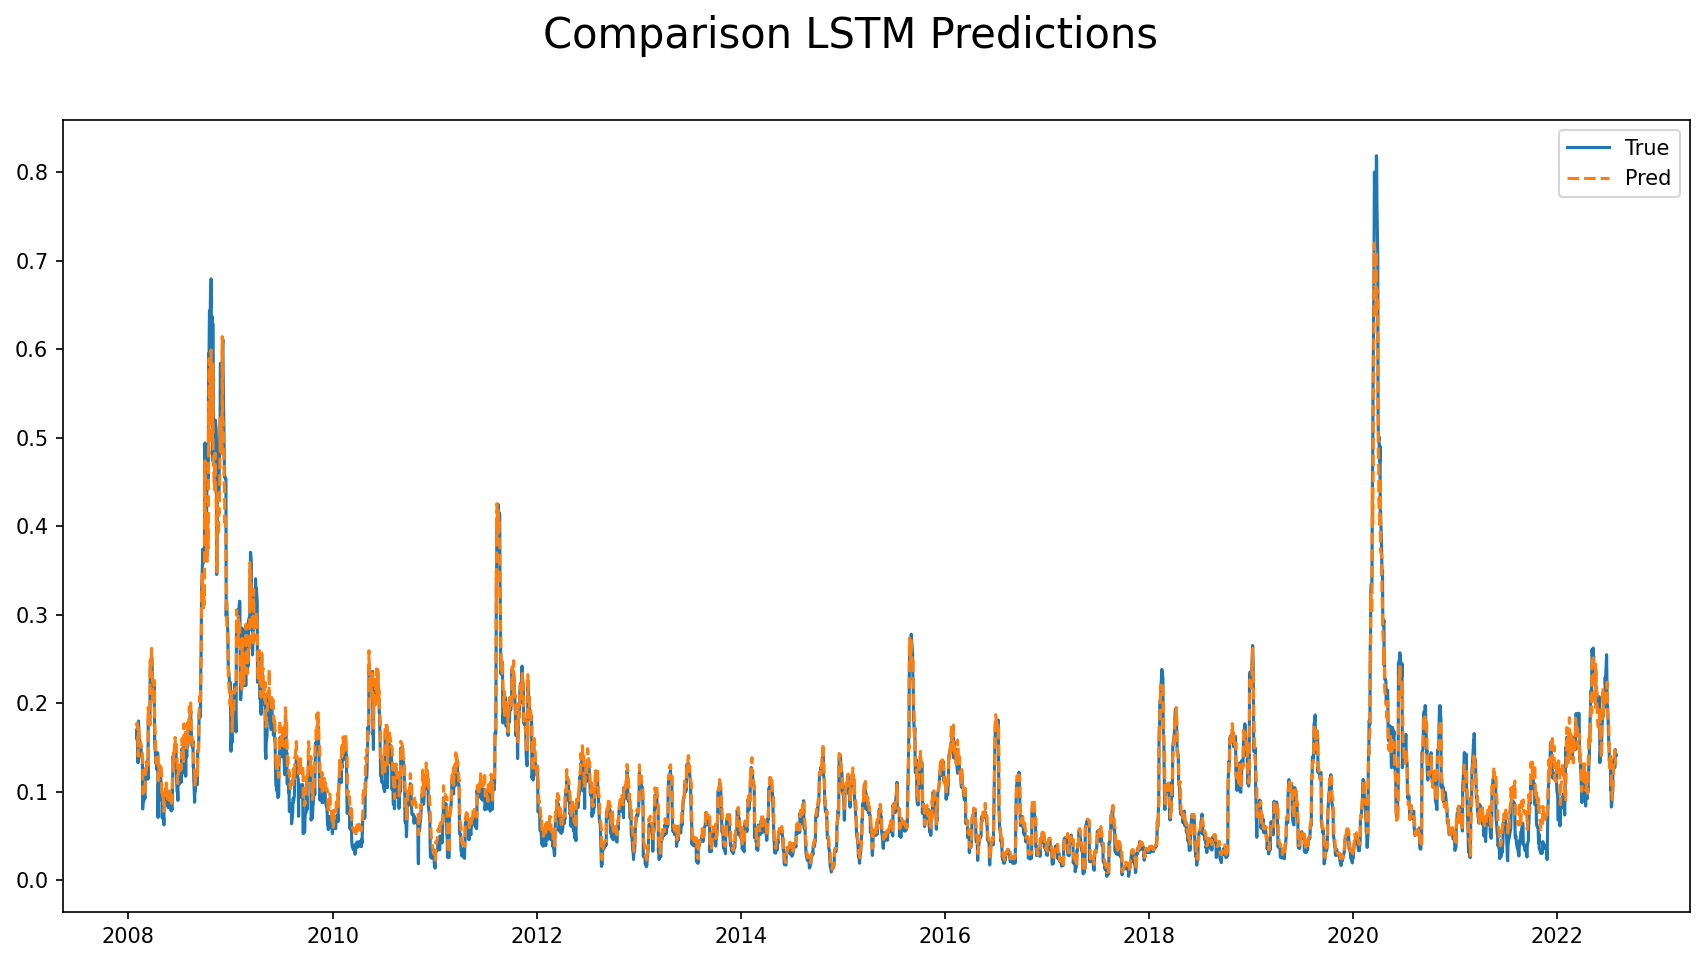

In [16]:
if BASELINE:
    # training loss plots
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7), dpi=150)
    fig1.suptitle("Loss/MSE over comparison model training", fontsize=20)

    ax1[0].plot(history_comp['loss'], color='b', label="MAE (training)")
    ax1[0].plot(history_comp['val_loss'], color='r', label="MAE (validation)")
    ax1[0].legend(loc=0)

    ax1[1].plot(history_comp['mse'], color='b', label="MSE (training)")
    ax1[1].plot(history_comp['val_mse'], color='y', label="MSE (validation)")
    ax1[1].legend(loc=0)

    try:
        fig1.savefig('./drive/MyDrive/UCL/Thesis/results/loss-baseline.png')
    except FileNotFoundError:
        fig1.savefig('./loss-baseline.png')

    # prediction plot
    y_pred_comp = comp_model.predict(X_test)
    y_pred_comp = y_pred_comp.flatten()
    y_pred_plot = pd.Series(y_pred_comp, index=X.returns[split + LOOKBACK_WINDOW:].keys())
    y_test_plot = pd.Series(y_test.flatten(), index=X.returns[split + LOOKBACK_WINDOW:].keys())

    fig2, ax2 = plt.subplots(figsize=(14, 7), dpi=150)
    fig2.suptitle("Comparison LSTM Predictions", fontsize=20)

    ax2.plot(y_test_plot, label='True')
    ax2.plot(y_pred_plot, linestyle='--', label='Pred')
    ax2.legend(loc=0)
    plt.show()

    try:
        fig2.savefig('./drive/MyDrive/UCL/Thesis/results/predictions-baseline.png')
    except FileNotFoundError:
        fig2.savefig('./predictions-baseline.png')

In [20]:
if BASELINE:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_comp)
    rmse = compute_rmse(y_test.flatten(), y_pred_comp)
    mape = compute_mape(y_test.flatten(), y_pred_comp)
    r_squared = r2_score(y_test.flatten(), y_pred_comp)

    print(f"mae = {mae:.5f}; rmse = {rmse:.5f}; r^2 = {r_squared:.5f}; mape = {mape:.5f}%")
    print(f"training time = {total_time_comp:.2f}s")

mae = 0.01145; mse = 0.00031; msle = 0.00021; r^2 = 0.96352; mape = 16.15847%
training time = 205.46s


### Supervised layer-wise training

In [21]:
# train the initial model
def base_model(X, y):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
        Dense(1, activation='linear')
    ])
    
    # compile and train base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])
    
    _start = time()
    hist = model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


# add a layer to the model and train it
def progress_layers(model, X, y, history, ret_seq=False):
    # save then remove output layer
    output = model.layers[-1]
    model.pop()

    # halt training on existing layers
    for l in model.layers: l.trainable = False

    # add new layer and restore output layer
    model.add(LSTM(NODES_PER_LAYER, return_sequences=ret_seq, activation='tanh'))
    model.add(output)

    # retrain newest layer (+ output layer)
    _start = time()
    hist = model.fit(X, y, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])
    history['mse'].extend(hist.history['mse'])
    history['val_mse'].extend(hist.history['val_mse'])

    return model, history, _timer


# final tuning over full model
def final_training(model, X, y):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='linear'))

    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train regressor
    _start = time()
    history = model.fit(X, y, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start
    
    return model, history.history, _timer

In [22]:
if PROGRESSIVE_TRAINING:
    sup_model, history_sup_pretraining, pretrain_time_sup = base_model(X_train, y_train)
    test_loss_1, test_acc_1 = sup_model.evaluate(X_test, y_test)

    sup_model, history_sup_pretraining, timer = progress_layers(sup_model, X_train, y_train, history_sup_pretraining, ret_seq=True)
    pretrain_time_sup += timer
    test_loss_2, test_acc_2 = sup_model.evaluate(X_test, y_test)

    sup_model, history_sup_tuning, tuning_time_sup = final_training(sup_model, X_train, y_train)

Epoch 1/30
92/92 [==============================] - 3s 22ms/step - loss: 0.0333 - mse: 0.0024 - val_loss: 0.0269 - val_mse: 0.0019
Epoch 2/30
92/92 [==============================] - 2s 18ms/step - loss: 0.0249 - mse: 0.0015 - val_loss: 0.0224 - val_mse: 0.0014
Epoch 3/30
92/92 [==============================] - 2s 18ms/step - loss: 0.0217 - mse: 0.0012 - val_loss: 0.0213 - val_mse: 0.0013
Epoch 4/30
92/92 [==============================] - 1s 13ms/step - loss: 0.0208 - mse: 0.0011 - val_loss: 0.0206 - val_mse: 0.0012
Epoch 5/30
92/92 [==============================] - 1s 13ms/step - loss: 0.0204 - mse: 0.0011 - val_loss: 0.0200 - val_mse: 0.0012
Epoch 6/30
92/92 [==============================] - 1s 13ms/step - loss: 0.0199 - mse: 0.0010 - val_loss: 0.0198 - val_mse: 0.0012
Epoch 7/30
92/92 [==============================] - 1s 13ms/step - loss: 0.0197 - mse: 9.8863e-04 - val_loss: 0.0194 - val_mse: 0.0011
Epoch 8/30
92/92 [==============================] - 1s 13ms/step - loss: 0.0194

In [23]:
if PROGRESSIVE_TRAINING:
    # Supervised model architecture
    sup_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 10)            720       
                                                                 
 lstm_4 (LSTM)               (None, 10, 10)            840       
                                                                 
 lstm_5 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,411
Trainable params: 2,411
Non-trainable params: 0
_________________________________________________________________


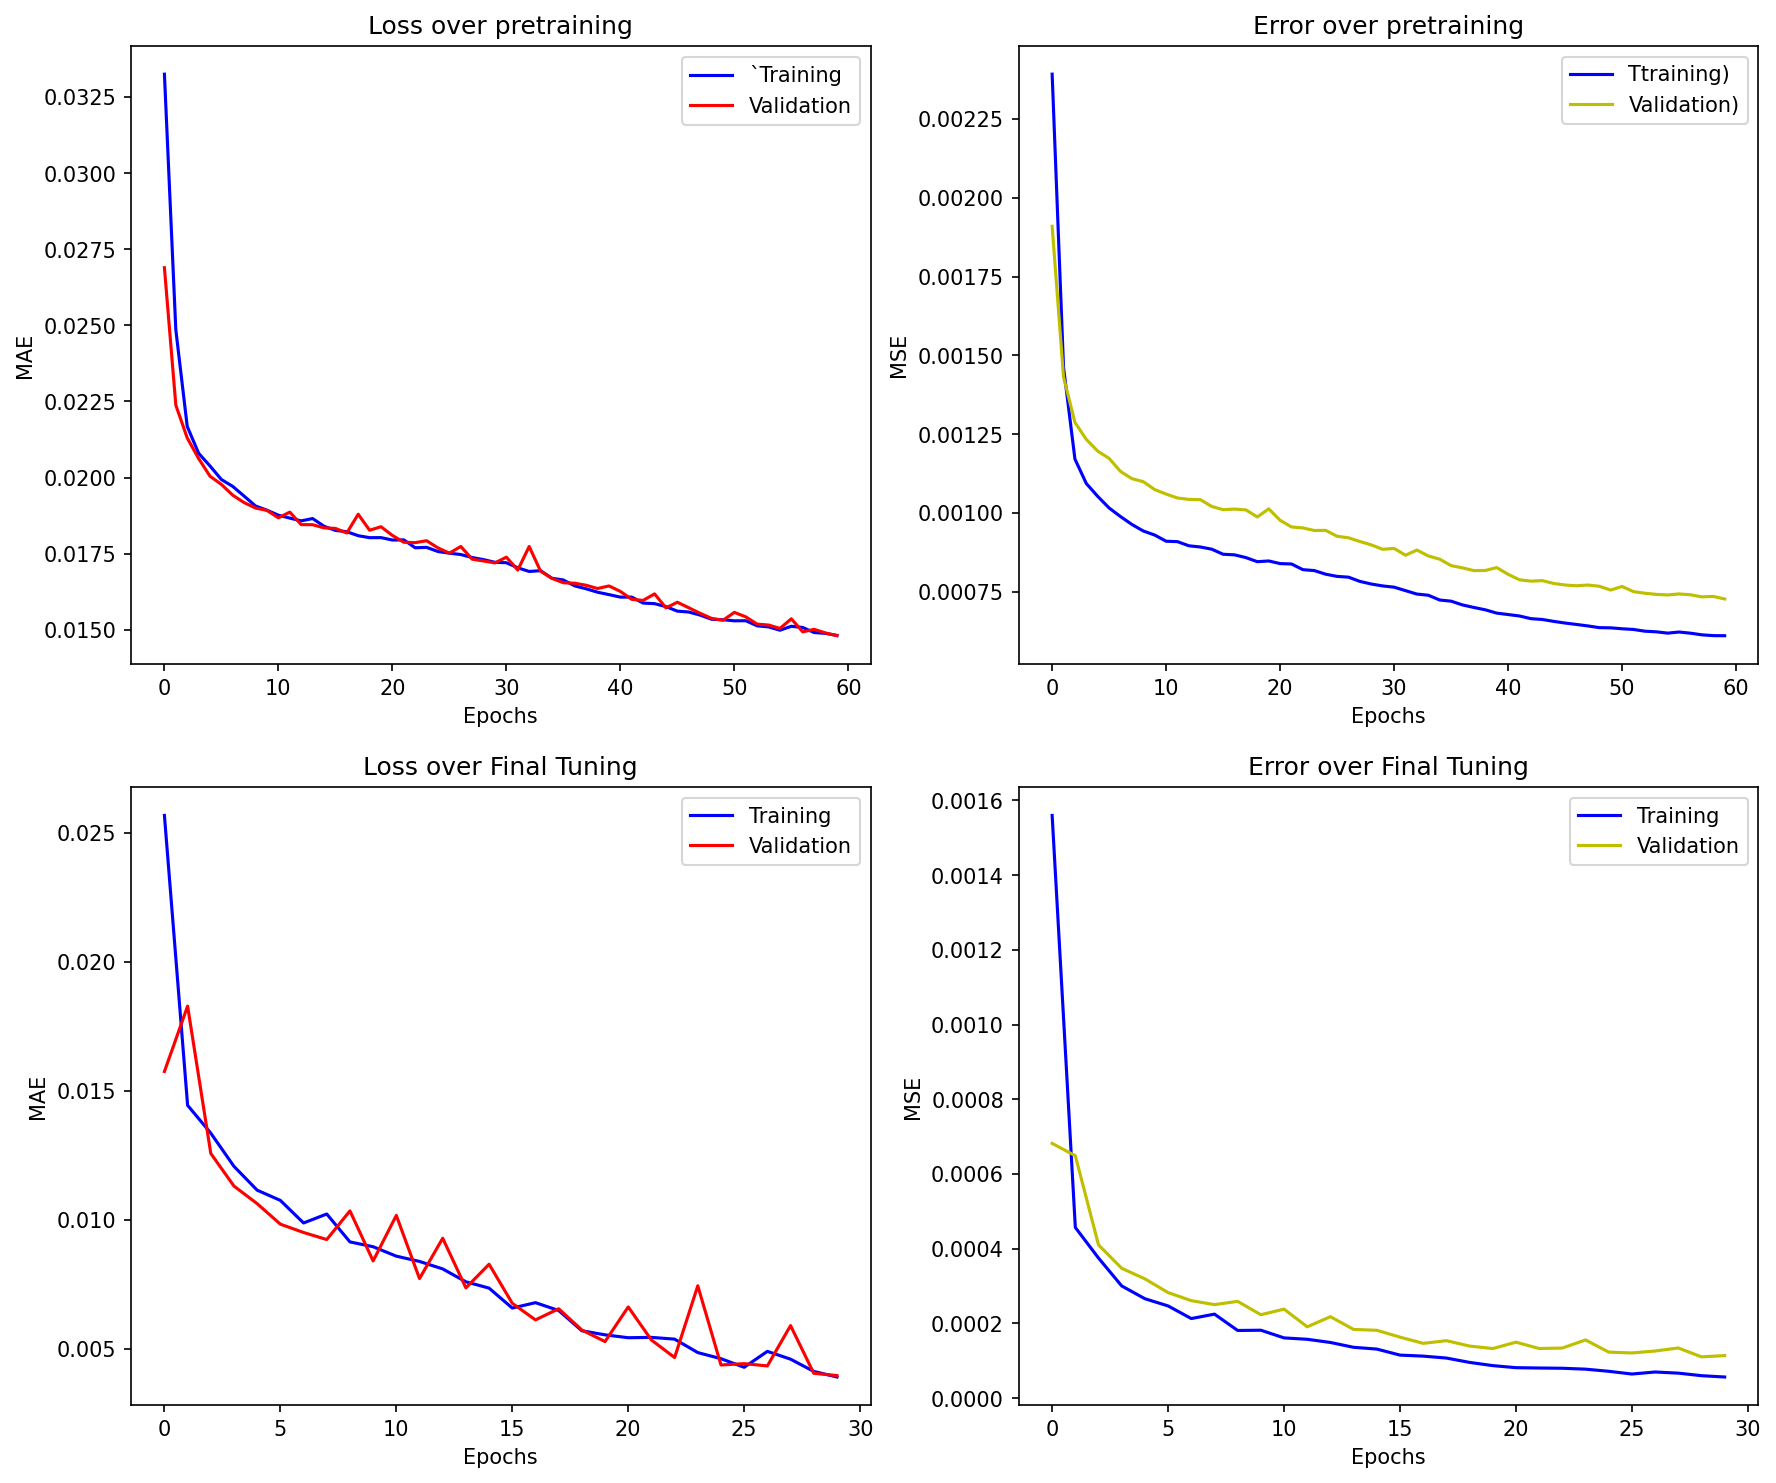

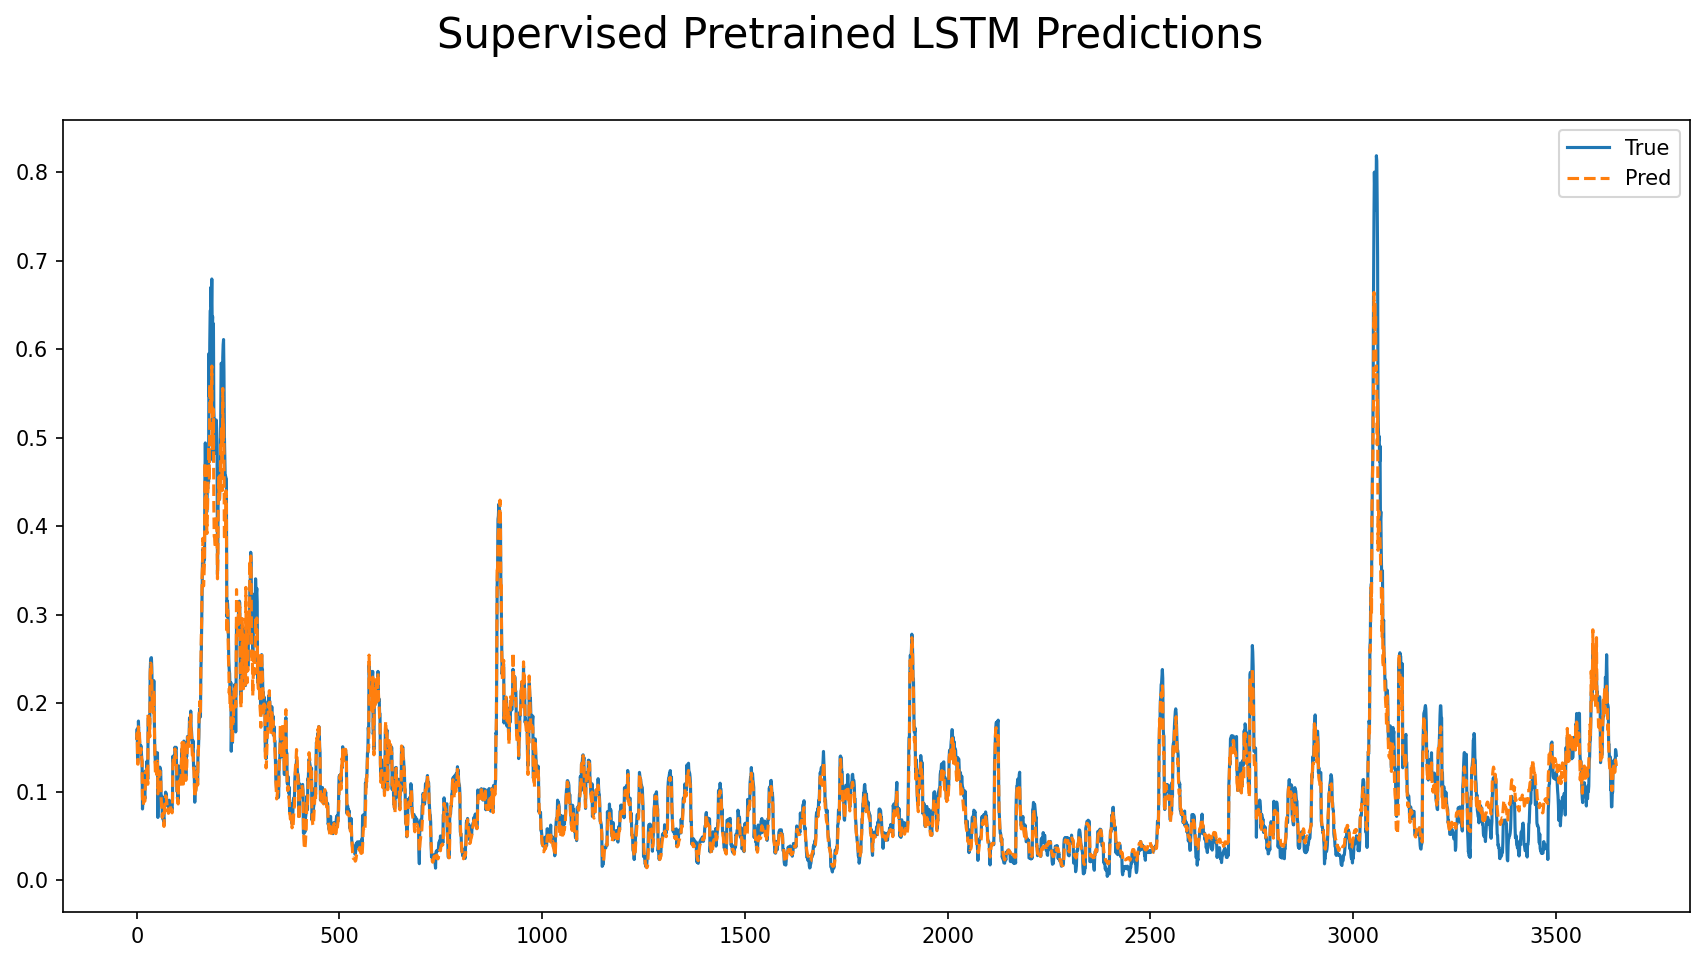

In [24]:
if PROGRESSIVE_TRAINING:
    # pretraining loss plots
    fig1, ax1 = plt.subplots(2, 2, figsize=(14, 12), dpi=150)

    ax1[0, 0].plot(history_sup_pretraining['loss'], color='b', label="Training")
    ax1[0, 0].plot(history_sup_pretraining['val_loss'], color='r', label="Validation")
    ax1[0, 0].legend(loc=0)
    ax1[0, 0].set(title='Loss over pretraining', xlabel='Epochs', ylabel='MAE')

    ax1[0, 1].plot(history_sup_pretraining['mse'], color='b', label="Training")
    ax1[0, 1].plot(history_sup_pretraining['val_mse'], color='y', label="Validation)")
    ax1[0, 1].legend(loc=0)
    ax1[0, 1].set(title='Error over pretraining', xlabel='Epochs', ylabel='MSE')

    # tuning loss plots
    ax1[1, 0].plot(history_sup_tuning['loss'], color='b', label="Training")
    ax1[1, 0].plot(history_sup_tuning['val_loss'], color='r', label="Validation")
    ax1[1, 0].legend(loc=0)
    ax1[1, 0].set(title='Loss over Final Tuning', xlabel='Epochs', ylabel='MAE')

    ax1[1, 1].plot(history_sup_tuning['mse'], color='b', label="Training")
    ax1[1, 1].plot(history_sup_tuning['val_mse'], color='y', label="Validation")
    ax1[1, 1].legend(loc=0)
    ax1[1, 1].set(title='Error over Final Tuning', xlabel='Epochs', ylabel='MSE')

    try:
        fig1.savefig('./drive/MyDrive/UCL/Thesis/results/loss-suplayerwise.png')
    except FileNotFoundError:
        fig1.savefig('./loss-suplayerwise.png')

    # prediction plot
    y_pred_sup = sup_model.predict(X_test)
    y_pred_sup = y_pred_sup.flatten()

    fig2, ax2 = plt.subplots(figsize=(14, 7), dpi=150)
    fig2.suptitle("Supervised Pretrained LSTM Predictions", fontsize=20)

    ax2.plot(y_test.flatten(), label='True')
    ax2.plot(y_pred_sup, linestyle='--', label='Pred')
    ax2.legend(loc=0)
    plt.show()

    try:
        fig2.savefig('./drive/MyDrive/UCL/Thesis/results/predictions-suplayerwise.png')
    except FileNotFoundError:
        fig2.savefig('./predictions-suplayerwise.png')

In [25]:
if PROGRESSIVE_TRAINING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_sup)
    rmse = compute_rmse(y_test.flatten(), y_pred_sup)
    mape = compute_mape(y_test.flatten(), y_pred_sup)
    r_squared = r2_score(y_test.flatten(), y_pred_sup)

    print(f"mae = {mae:.5f}; rmse = {rmse:.5f}; r^2 = {r_squared:.5f}; mape = {mape:.5f}%")
    print(f"pretraining time = {pretrain_time_sup:.2f}s; final tuning time = {tuning_time_sup:.2f}s; total time = {pretrain_time_sup + tuning_time_sup:.2f}s")

mae = 0.01041; mse = 0.00038; msle = 0.00022; r^2 = 0.95546; mape = 15.25570%
pretraining time = 124.34s; final tuning time = 55.70s; total time = 180.04s


### Unsupervised layer-wise training

In [26]:
# initial autoencoder model
def base_autoencoder(X):
    # define base model
    model = Sequential([
        LSTM(NODES_PER_LAYER, activation='tanh', return_sequences=True, input_shape=(X.shape[1:])),
        TimeDistributed(Dense(X.shape[2]))
    ])

    # compile base model
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mse', optimizer=optim)

    # train model as an autoencoder that recreates its inputs (minimising mse between input and ouput)
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, hist.history, _timer


# adding layers to autoencoder model
def add_autoencoder(model, X, history):
    # stash output layer
    output = model.layers[-1]
    model.pop()

    # fix weights of autoencoder layers (note, this is redundant if `evaluate_regression` called beforehand)
    for l in model.layers: l.trainable = False

    # add new autoencoder layer and read output layer
    model.add(LSTM(NODES_PER_LAYER, activation='tanh', return_sequences=True))
    model.add(output)

    # train new autoencoder layer
    _start = time()
    hist = model.fit(X, X, epochs=PRETRAINING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    # collect metrics
    history['loss'].extend(hist.history['loss'])
    history['val_loss'].extend(hist.history['val_loss'])

    return model, history, _timer


# conversion of model into a regressor, and final tuning rounds
def build_final_model(model, X, y):
    # remove encoder output layer
    model.pop()

    # make all layers tunable again
    for l in model.layers: l.trainable = True

    # add final LSTM layer and regressor output layer to predict a single value
    model.add(LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'))
    model.add(Dense(1, activation='linear'))
    
    # recompile with regression loss function
    optim = Adam(learning_rate=0.001, decay=1e-5)
    model.compile(loss='mae', optimizer=optim, metrics=['mse'])

    # train regressor
    _start = time()
    history = model.fit(X, y, epochs=TUNING_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
    _timer = time() - _start

    return model, history.history, _timer

In [27]:
if PROGRESSIVE_TRAINING:
    encoder, enc_history, total_enc_time = base_autoencoder(X_train)
    encoder, enc_history, timer = add_autoencoder(encoder, X_train, enc_history)
    total_enc_time += timer
    
    regressor, reg_history, total_reg_time = build_final_model(encoder, X_train, y_train)

Epoch 1/30
92/92 [==============================] - 3s 15ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 2/30
92/92 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 3/30
92/92 [==============================] - 1s 11ms/step - loss: 9.4604e-04 - val_loss: 8.1697e-04
Epoch 4/30
92/92 [==============================] - 2s 18ms/step - loss: 6.9739e-04 - val_loss: 6.0947e-04
Epoch 5/30
92/92 [==============================] - 1s 11ms/step - loss: 5.2430e-04 - val_loss: 4.6561e-04
Epoch 6/30
92/92 [==============================] - 2s 17ms/step - loss: 3.9424e-04 - val_loss: 3.4861e-04
Epoch 7/30
92/92 [==============================] - 1s 11ms/step - loss: 2.9779e-04 - val_loss: 2.6476e-04
Epoch 8/30
92/92 [==============================] - 1s 11ms/step - loss: 2.2548e-04 - val_loss: 2.0372e-04
Epoch 9/30
92/92 [==============================] - 1s 11ms/step - loss: 1.7341e-04 - val_loss: 1.5876e-04
Epoch 10/30
92/92 [==============================] - 

In [28]:
if PROGRESSIVE_TRAINING:
    # Unsupervised model architecture
    regressor.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 10, 10)            720       
                                                                 
 lstm_7 (LSTM)               (None, 10, 10)            840       
                                                                 
 lstm_8 (LSTM)               (None, 10)                840       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,411
Trainable params: 2,411
Non-trainable params: 0
_________________________________________________________________


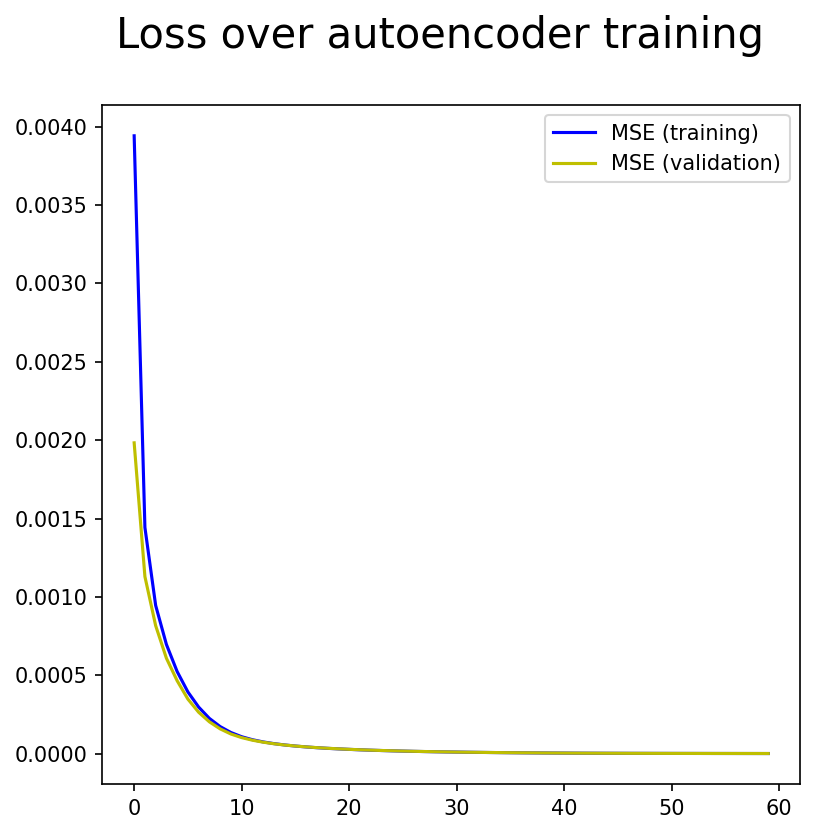

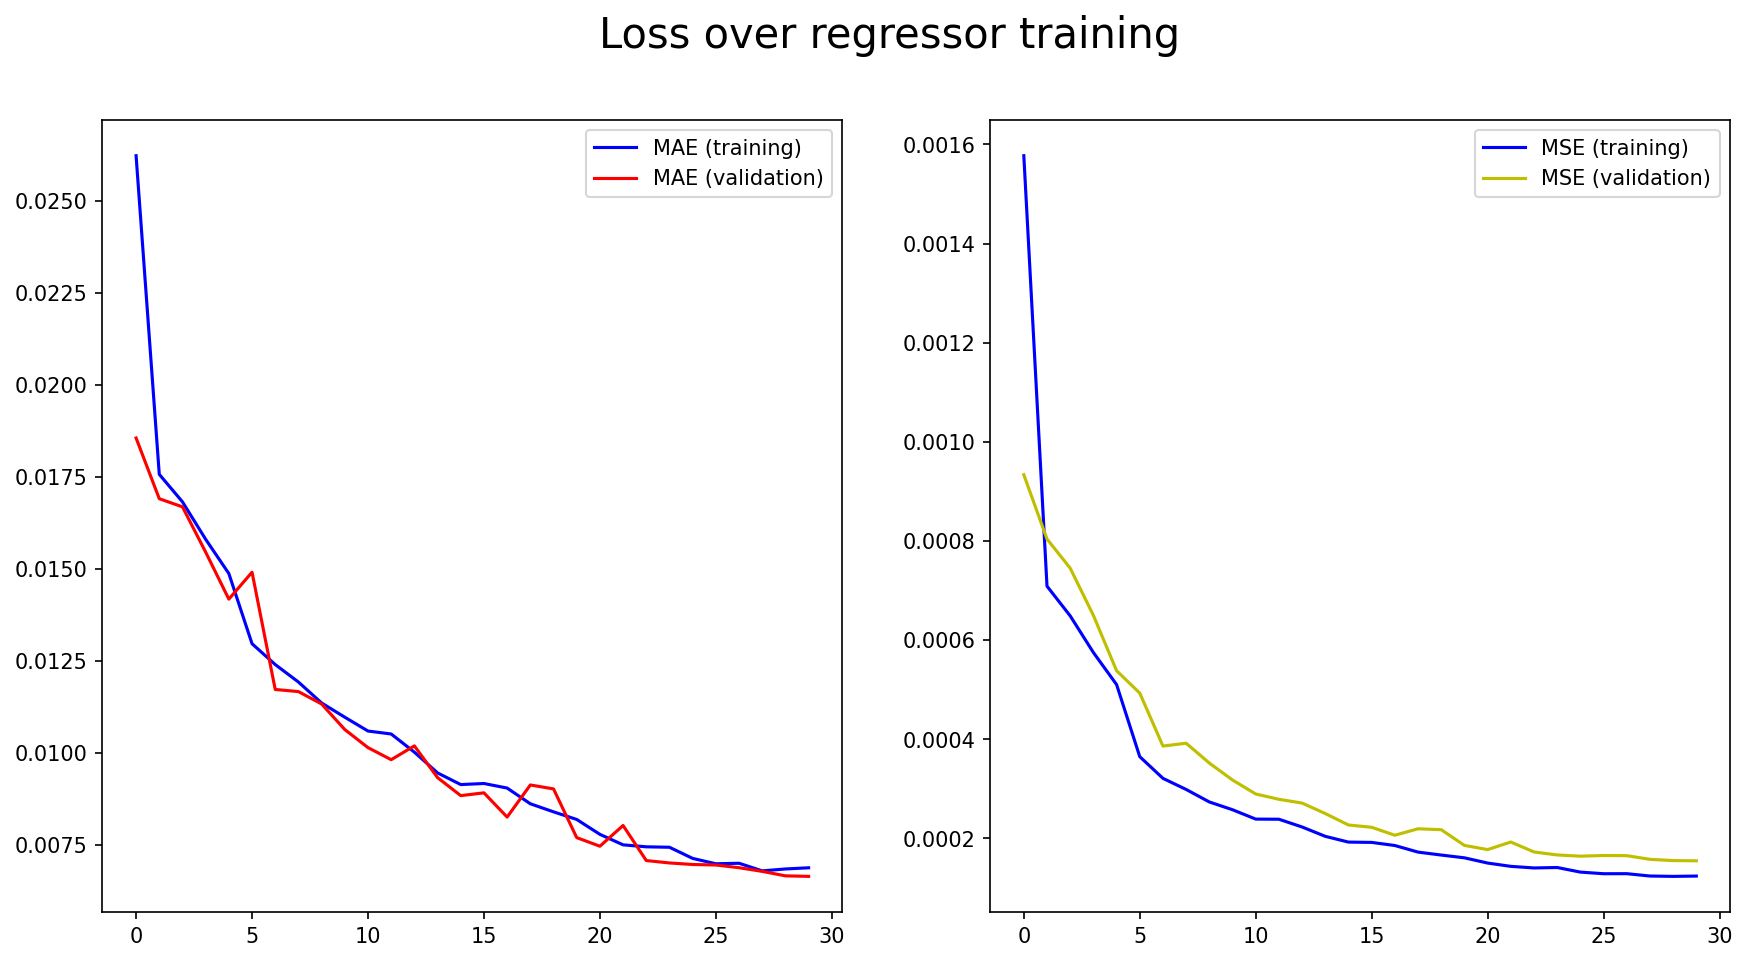

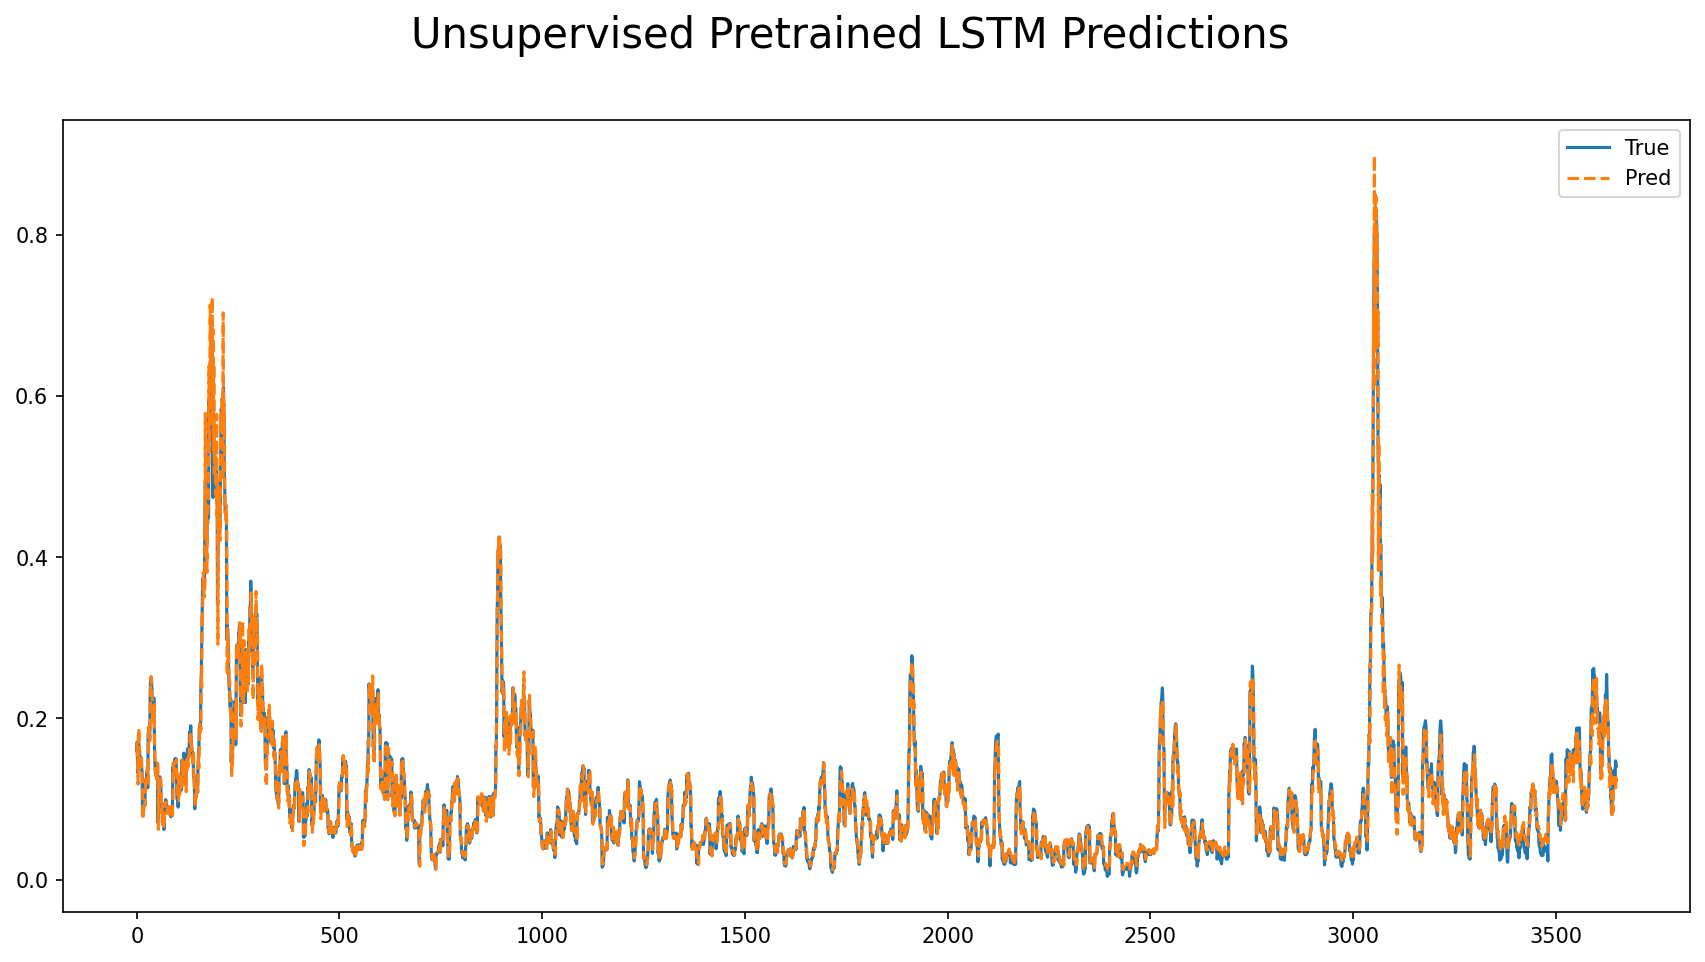

In [29]:
if PROGRESSIVE_TRAINING:
    # autoencoder loss plots
    fig1, ax1 = plt.subplots(figsize=(6, 6), dpi=150)
    fig1.suptitle("Loss over autoencoder training", fontsize=20)

    ax1.plot(enc_history['loss'], color='b', label="MSE (training)")
    ax1.plot(enc_history['val_loss'], color='y', label="MSE (validation)")
    ax1.legend(loc=0)

    try:
        fig1.savefig('./drive/MyDrive/UCL/Thesis/results/loss-unsuplayerwise-encoder.png')
    except FileNotFoundError:
        fig1.savefig('./loss-unsuplayerwise-encoder.png')

    # regressor loss plots
    fig2, ax2 = plt.subplots(1, 2, figsize=(14, 7), dpi=150)
    fig2.suptitle("Loss over regressor training", fontsize=20)

    ax2[0].plot(reg_history['loss'], color='b', label="MAE (training)")
    ax2[0].plot(reg_history['val_loss'], color='r', label="MAE (validation)")
    ax2[0].legend(loc=0)

    ax2[1].plot(reg_history['mse'], color='b', label="MSE (training)")
    ax2[1].plot(reg_history['val_mse'], color='y', label="MSE (validation)")
    ax2[1].legend(loc=0)

    try:
        fig2.savefig('./drive/MyDrive/UCL/Thesis/results/loss-unsuplayerwise-regressor.png')
    except FileNotFoundError:
        fig2.savefig('./loss-unsuplayerwise-regressor.png')

    # prediction plot
    y_pred_unsup = regressor.predict(X_test)
    y_pred_unsup = y_pred_unsup.flatten()

    fig3, ax3 = plt.subplots(figsize=(14, 7), dpi=150)
    fig3.suptitle("Unsupervised Pretrained LSTM Predictions", fontsize=20)

    ax3.plot(y_test.flatten(), label='True')
    ax3.plot(y_pred_unsup, linestyle='--', label='Pred')
    ax3.legend(loc=0)
    plt.show()

    try:
        fig3.savefig('./drive/MyDrive/UCL/Thesis/results/predictions-unsuplayerwise.png')
    except FileNotFoundError:
        fig3.savefig('./predictions-unsuplayerwise.png')

In [30]:
if PROGRESSIVE_TRAINING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_unsup)
    rmse = compute_rmse(y_test.flatten(), y_pred_unsup)
    mape = compute_mape(y_test.flatten(), y_pred_unsup)
    r_squared = r2_score(y_test.flatten(), y_pred_unsup)

    print(f"mae = {mae:.5f}; rmse = {rmse:.5f}; r^2 = {r_squared:.5f}; mape = {mape:.5f}%")
    print(f"autoencoder training time = {total_enc_time:.2f}s; regressor training time = {total_reg_time:.2f}s; total time = {total_enc_time + total_reg_time:.2f}s")

mae = 0.00987; mse = 0.00028; msle = 0.00019; r^2 = 0.96671; mape = 12.74457%
autoencoder training time = 80.93s; regressor training time = 55.82s; total time = 136.76s


### Active Learning

In [31]:
# GSx sampling for initial seed pool
def initial_selection(X, y, k=AL_SAMPLE):
    # select first sample as closest to centroid of all training samples
    centroid = np.mean(X, axis=0)

    # compute euclidean distance
    distances = np.max(np.linalg.norm(X - centroid, axis=2), axis=1)

    # select instances with smallest distance
    train_indices = np.argpartition(distances, k)[:k]
    X_instances = X[train_indices]
    y_instances = y[train_indices]

    # gather remaining instances
    val_indices = np.setdiff1d(range(X.shape[0]), train_indices)
    X_instances_val = X[val_indices]
    y_instances_val = y[val_indices]

    return X_instances, y_instances, X_instances_val, y_instances_val


# GSy sampling for selecting instances to add to training pool
def select_instances(model, X_t, y_t, X_v, y_v, k=AL_SAMPLE):
    # generate outputs y over validation set
    y_pred = model.predict(X_v)
    
    # for each prediction, find the minimum distance to an output in the training set
    _y_pred = y_pred.flatten()
    _y_t = y_t.flatten()
    distances = np.min(np.abs(_y_pred[:, np.newaxis] - _y_t), axis=1)

    # select new training instances as those furthest from training set outputs
    train_indices = np.argpartition(distances, -k)[-k:]
    val_indices = np.setdiff1d(range(X_v.shape[0]), train_indices)

    X_t = np.append(X_t, X_v[train_indices], axis=0)
    y_t = np.append(y_t, y_v[train_indices], axis=0)
    X_v = X_v[val_indices]
    y_v = y_v[val_indices]

    return X_t, y_t, X_v, y_v

In [32]:
if ACTIVE_LEARNING:
    # build RNN/LSTM architecture
    lstm_model = Sequential([
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
        LSTM(NODES_PER_LAYER, return_sequences=True, activation='tanh'),
        LSTM(NODES_PER_LAYER, return_sequences=False, activation='tanh'),
        Dense(1, activation='linear')
    ])

    adam_opt = Adam(learning_rate=0.001, decay=1e-5)
    lstm_model.compile(loss='mae', optimizer=adam_opt, metrics=['mse'])

In [33]:
if ACTIVE_LEARNING:
    # active learning training
    histories = {}
    total_time_al = 0

    # initial training over seed dataset
    _start = time()
    X_pool, y_pool, X_val, y_val = initial_selection(X_train, y_train)
    history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT, verbose=False)
    total_time_al += time() - _start

    # store metrics
    histories.update({
        'loss': [np.min(history.history['loss'])],
        'mse': [np.min(history.history['mse'])],
        'val_loss': [np.min(history.history['val_loss'])],
        'val_mse': [np.min(history.history['val_mse'])]
    })

    # iteratively train model
    for it in range(AL_ITERATIONS):
        print(f"Iteration {it+1}/{AL_ITERATIONS}; pool = {X_pool.shape[0]}, val = {X_val.shape[0]}")
        if X_val.shape[0] >= AL_SAMPLE:
            _start = time()

            # use GSy method to select samples to add to the training pool
            X_pool, y_pool, X_val, y_val = select_instances(lstm_model, X_pool, y_pool, X_val, y_val)

            # train model over pool
            history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
            total_time_al += time() - _start
            
            # store metrics
            histories['loss'].append(np.min(history.history['loss']))
            histories['mse'].append(np.min(history.history['mse']))
            histories['val_loss'].append(np.min(history.history['val_loss']))
            histories['val_mse'].append(np.min(history.history['val_mse']))
        else:
            break

Iteration 1/100; pool = 100, val = 14500
Epoch 1/2
2/2 [==============================] - 0s 80ms/step - loss: 0.0440 - mse: 0.0020 - val_loss: 0.2124 - val_mse: 0.0979
Epoch 2/2
2/2 [==============================] - 0s 85ms/step - loss: 0.0257 - mse: 7.5419e-04 - val_loss: 0.1923 - val_mse: 0.0888
Iteration 2/100; pool = 200, val = 14400
Epoch 1/2
2/2 [==============================] - 0s 74ms/step - loss: 0.0107 - mse: 1.8890e-04 - val_loss: 0.1860 - val_mse: 0.0685
Epoch 2/2
2/2 [==============================] - 0s 47ms/step - loss: 0.0127 - mse: 2.2659e-04 - val_loss: 0.1771 - val_mse: 0.0642
Iteration 3/100; pool = 300, val = 14300
Epoch 1/2
3/3 [==============================] - 0s 45ms/step - loss: 0.0193 - mse: 4.9287e-04 - val_loss: 0.1372 - val_mse: 0.0476
Epoch 2/2
3/3 [==============================] - 0s 45ms/step - loss: 0.0184 - mse: 4.5279e-04 - val_loss: 0.1419 - val_mse: 0.0492
Iteration 4/100; pool = 400, val = 14200
Epoch 1/2
4/4 [==============================] -

In [34]:
if ACTIVE_LEARNING:
    lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 10, 10)            720       
                                                                 
 lstm_10 (LSTM)              (None, 10, 10)            840       
                                                                 
 lstm_11 (LSTM)              (None, 10)                840       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,411
Trainable params: 2,411
Non-trainable params: 0
_________________________________________________________________


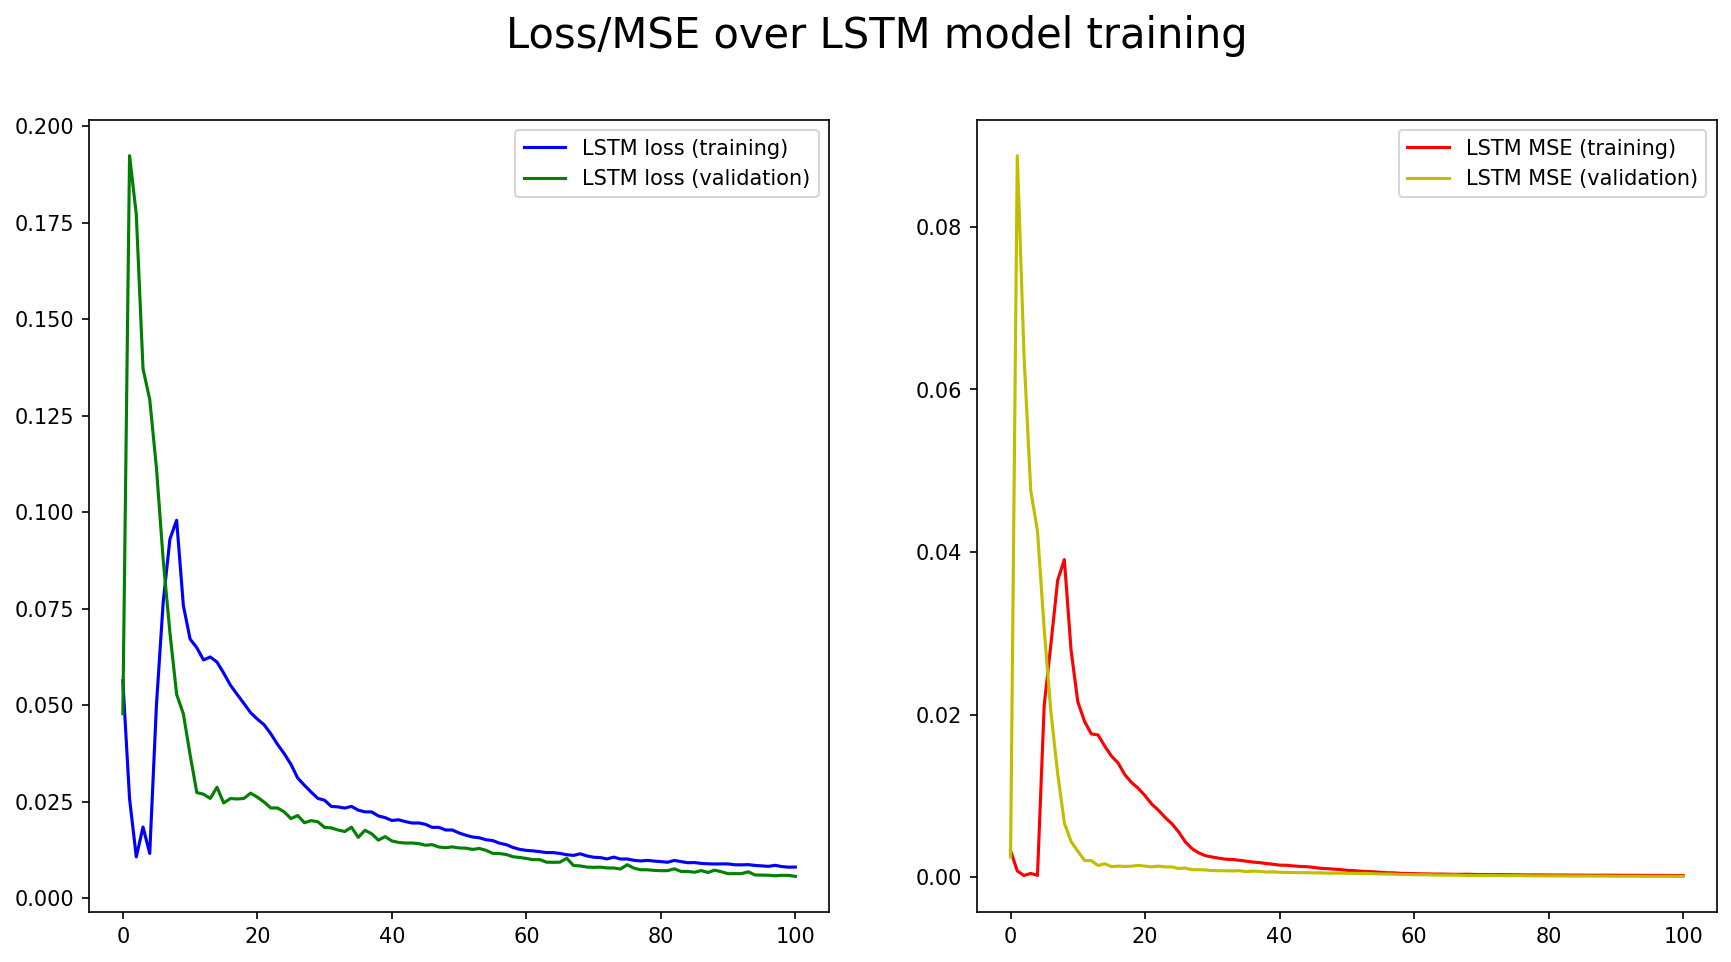

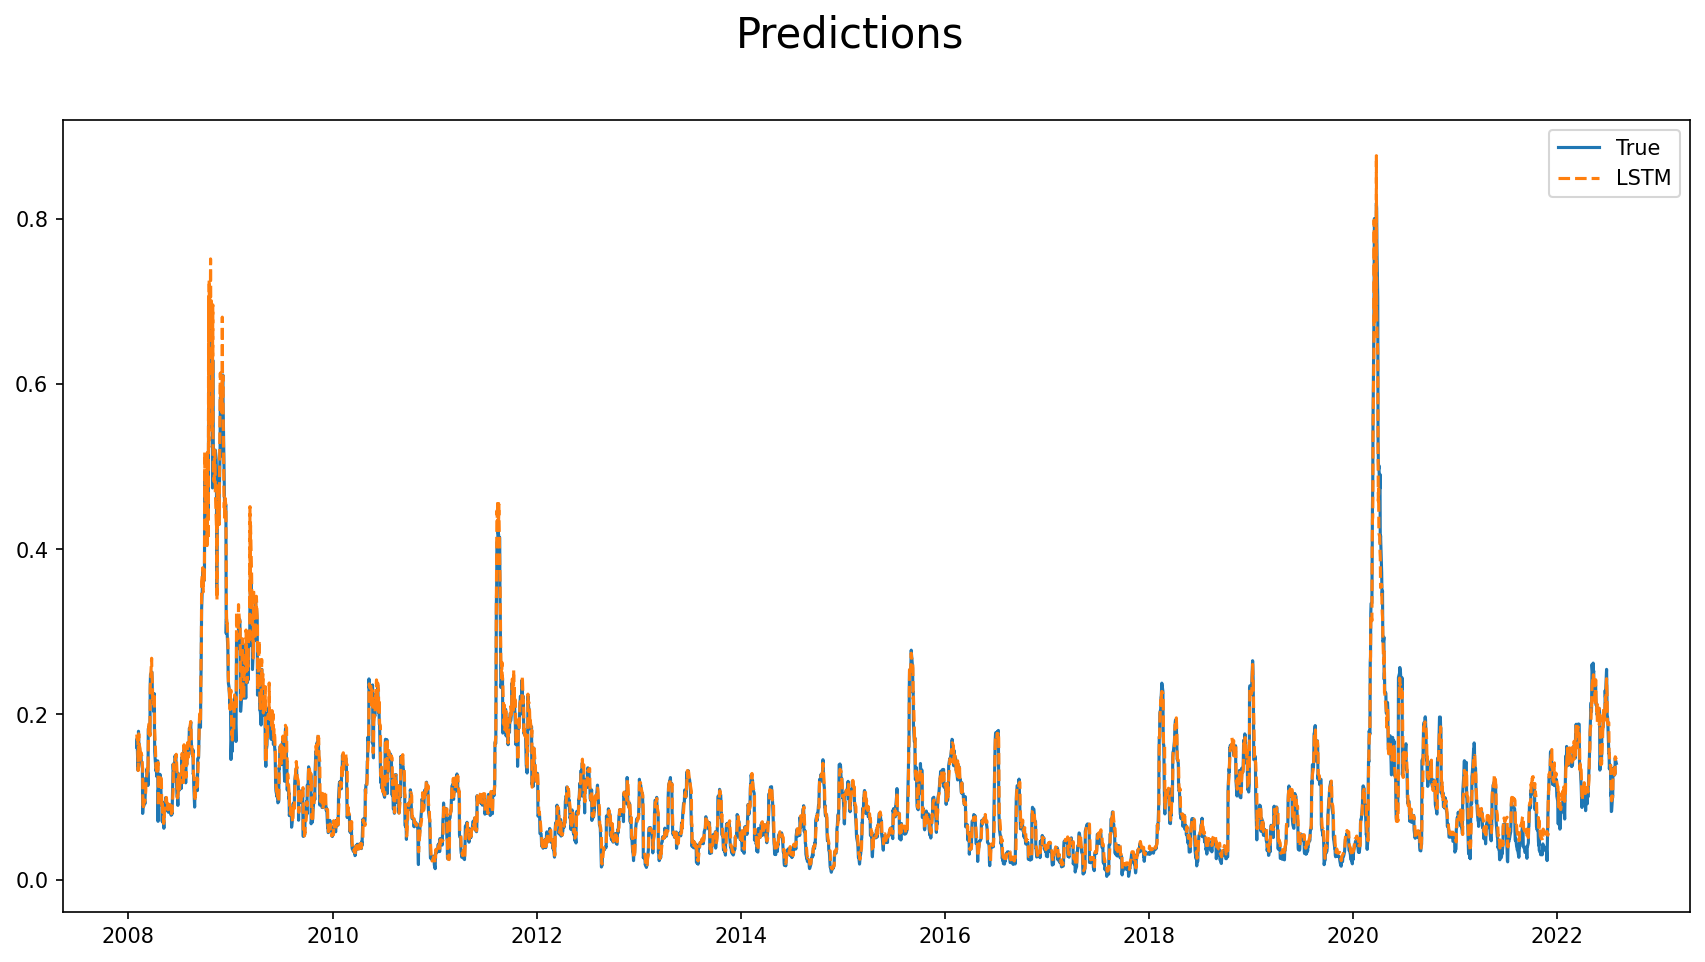

In [35]:
if ACTIVE_LEARNING:
    # training loss plot
    fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7), dpi=150)
    fig1.suptitle("Loss/MSE over LSTM model training", fontsize=20)

    ax1[0].plot(histories['loss'], color='b', label="LSTM loss (training)")
    ax1[0].plot(histories['val_loss'], color='g', label="LSTM loss (validation)")
    ax1[0].legend(loc=0)

    ax1[1].plot(histories['mse'], color='r', label="LSTM MSE (training)")
    ax1[1].plot(histories['val_mse'], color='y', label="LSTM MSE (validation)")
    ax1[1].legend(loc=0)

    try:
        fig1.savefig('./drive/MyDrive/UCL/Thesis/results/loss-active.png')
    except FileNotFoundError:
        fig1.savefig('./loss-active.png')

    # prediction plot
    y_pred_al = lstm_model.predict(X_test)
    y_pred_al = y_pred_al.flatten()
    y_test_plot = pd.Series(y_test.flatten(), index=X.returns[split + LOOKBACK_WINDOW:].keys())

    fig2, ax2 = plt.subplots(figsize=(14, 7), dpi=150)
    fig2.suptitle("Predictions", fontsize=20)

    y_pred_plot = pd.Series(y_pred_al, index=X.returns[split + LOOKBACK_WINDOW:].keys())

    ax2.plot(y_test_plot, label='True')
    ax2.plot(y_pred_plot, linestyle='--', label='LSTM')
    ax2.legend(loc=0)
    plt.show()

    try:
        fig2.savefig('./drive/MyDrive/UCL/Thesis/results/predictions-active.png')
    except FileNotFoundError:
        fig2.savefig('./predictions-active.png')

In [36]:
if ACTIVE_LEARNING:
    # metrics
    mae = compute_mae(y_test.flatten(), y_pred_al)
    rmse = compute_rmse(y_test.flatten(), y_pred_al)
    mape = compute_mape(y_test.flatten(), y_pred_al)
    r_squared = r2_score(y_test.flatten(), y_pred_al)

    print(f"mae = {mae:.5f}; rmse = {rmse:.5f}; r^2 = {r_squared:.5f}; mape = {mape:.5f}%")
    print(f"training time = {total_time_al:.2f}s")

mae = 0.00877; mse = 0.00022; msle = 0.00015; r^2 = 0.97363; mape = 12.59257%
training time = 264.97s
